Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

## Mobility of Countries

In [2]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(country_df):
    country_df = country_df[country_df['Participant Profile']=='Learner']
    country_df = country_df[country_df['Activity (mob)'].str.contains('Student')]
    country_df = country_df[~country_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(country_df.loc[:, 'Sending Country Code' ]), set(country_df.loc[:, 'Receiving Country Code']))))
    country_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
    country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
    # Adjacency matrix
    country_serie = country_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

    country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
    country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
    nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank authority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank authority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = country_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = country_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

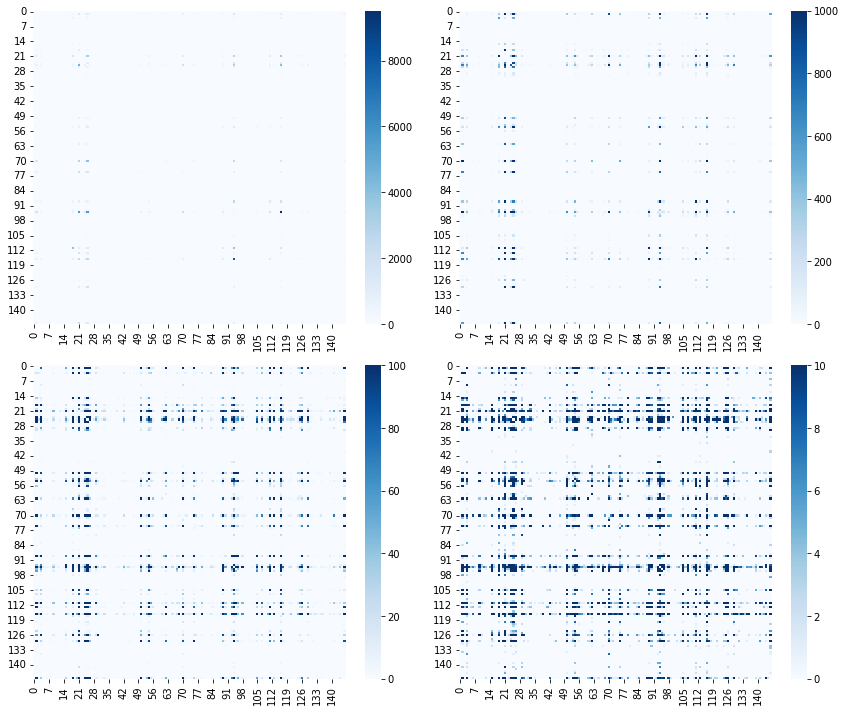

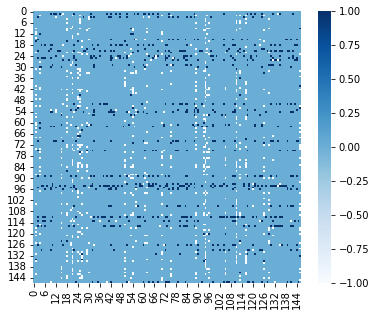

Number of components = 2


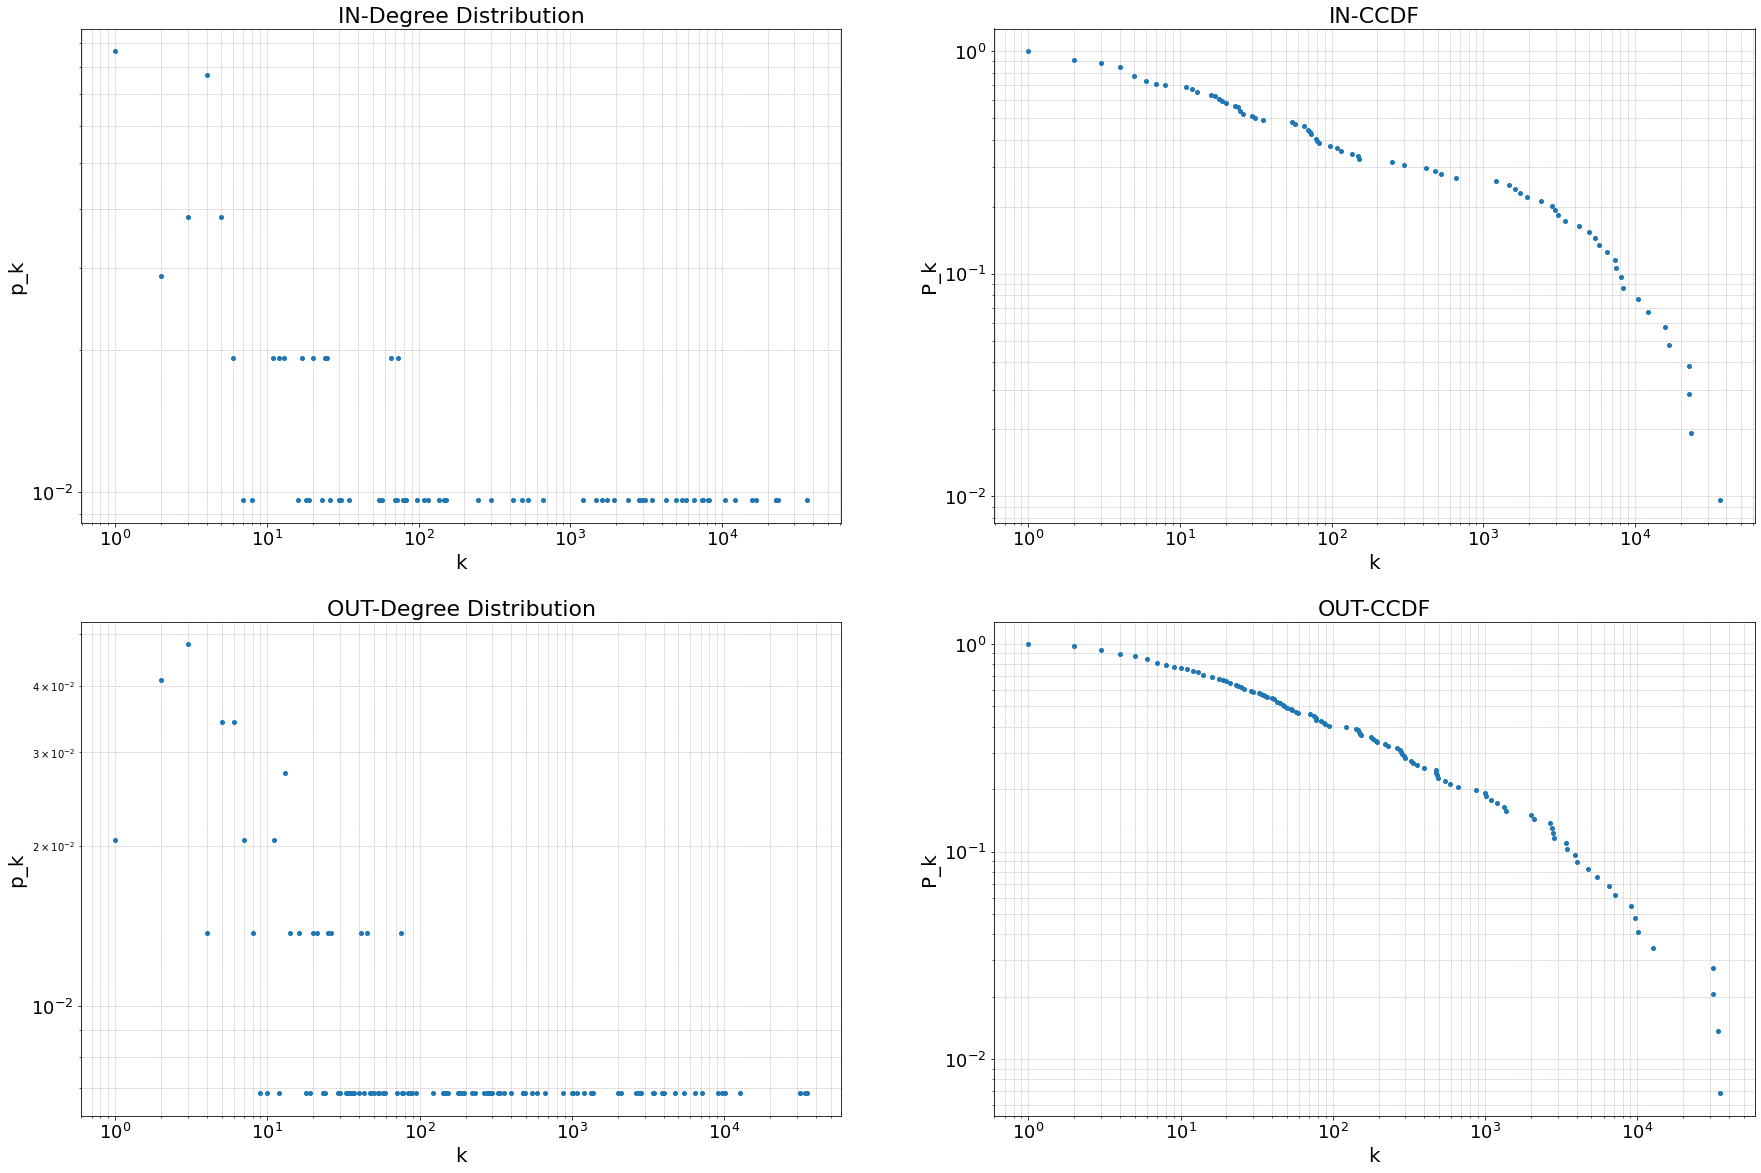

Top 10 for in degree


Nodes  in degree
94         Spain      36263
116        Italy      23344
25        France      22790
21       Germany      22538
70            UK      16849
111       Poland      15750
89      Portugal      12151
1    Netherlands      10510
75        Sweden       8268
54       Czechia       8079

Top 10 for out degree


Nodes  out degree
94         Spain       34913
21       Germany       33931
116        Italy       31591
25        France       31235
18        Turkey       12738
1    Netherlands       10144
111       Poland        9630
70            UK        9086
89      Portugal        7144
24       Belgium        6471

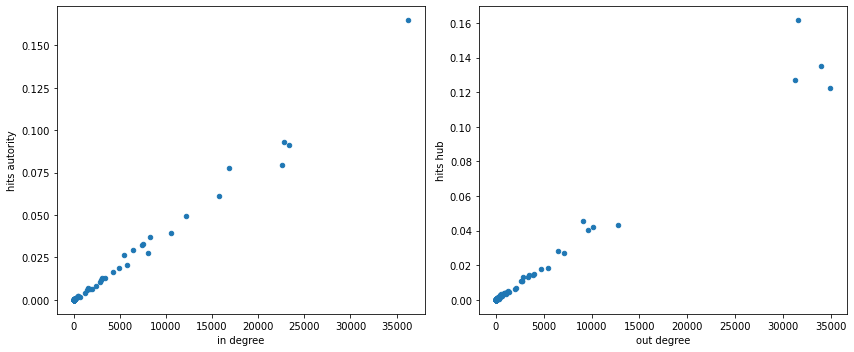

Top 10 for hits hub


Nodes  hits hub
116        Italy  0.161576
21       Germany  0.135408
25        France  0.127085
94         Spain  0.122200
70            UK  0.045554
18        Turkey  0.043050
1    Netherlands  0.042306
111       Poland  0.040657
24       Belgium  0.028275
89      Portugal  0.027016

Top 10 for hits autority


Nodes  hits autority
94         Spain       0.164803
25        France       0.093283
116        Italy       0.091191
21       Germany       0.079345
70            UK       0.077596
111       Poland       0.061080
89      Portugal       0.049354
1    Netherlands       0.039346
75        Sweden       0.036828
146      Finland       0.033024

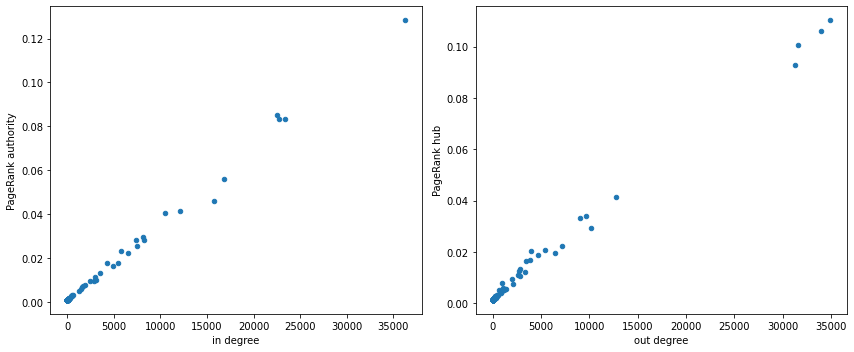

Top 10 for PageRank hub


Nodes  PageRank hub
94         Spain      0.110257
21       Germany      0.105996
116        Italy      0.100815
25        France      0.093048
18        Turkey      0.041473
111       Poland      0.033889
70            UK      0.033424
1    Netherlands      0.029289
89      Portugal      0.022390
54       Czechia      0.020962

Top 10 for PageRank authority


Nodes  PageRank authority
94         Spain            0.128283
21       Germany            0.084965
116        Italy            0.083311
25        France            0.083270
70            UK            0.056150
111       Poland            0.046034
89      Portugal            0.041512
1    Netherlands            0.040408
54       Czechia            0.029744
24       Belgium            0.028452

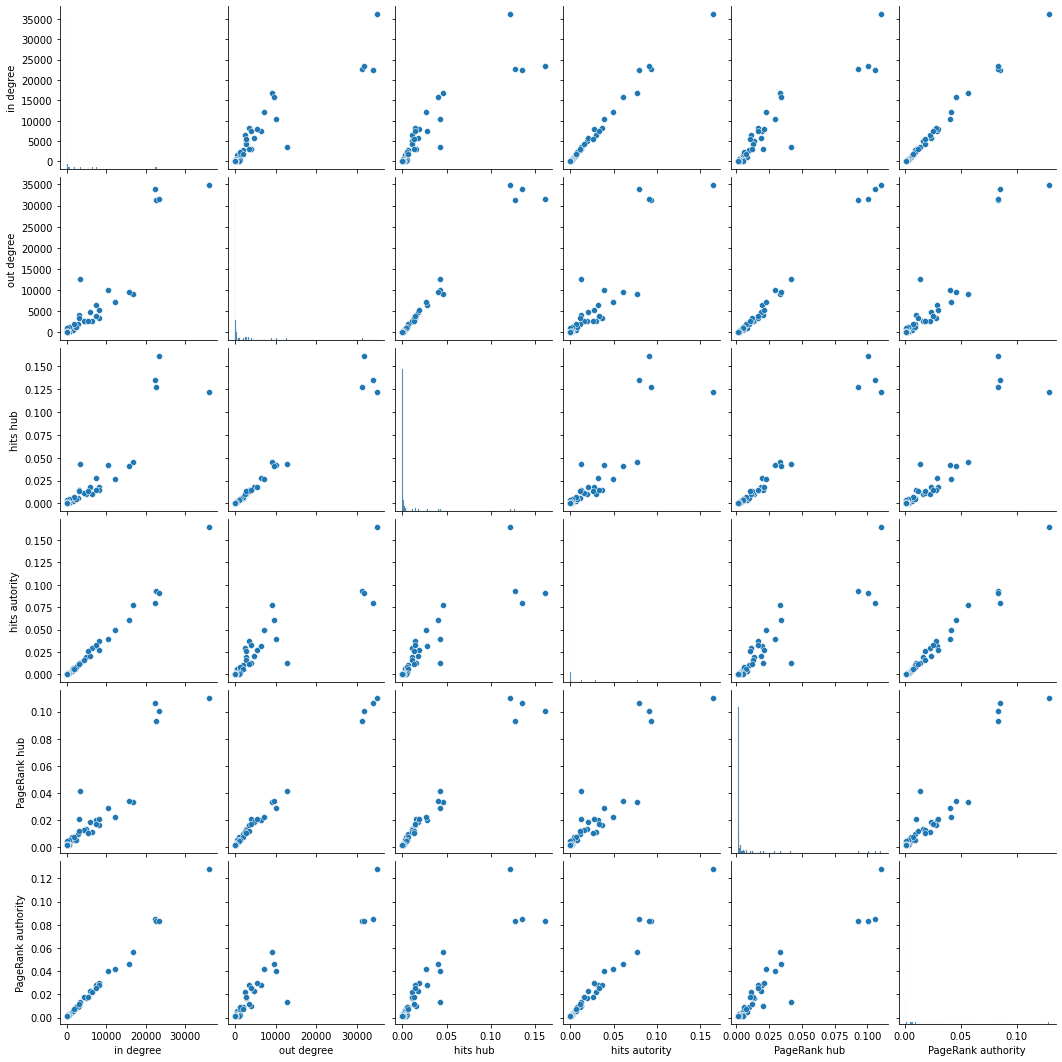

Nodes  in degree  in degree position  hits autority  \
94                Spain      36263                   1       0.164803   
21              Germany      22538                   4       0.079345   
116               Italy      23344                   2       0.091191   
25               France      22790                   3       0.093283   
70                   UK      16849                   5       0.077596   
111              Poland      15750                   6       0.061080   
89             Portugal      12151                   7       0.049354   
1           Netherlands      10510                   8       0.039346   
54              Czechia       8079                  10       0.027760   
24              Belgium       7416                  12       0.032101   
75               Sweden       8268                   9       0.036828   
146             Finland       7517                  11       0.033024   
50              Austria       5808                  14       0.020285   
113              Norway       6494                  13       0.029125   
129             Ireland       5419                  15       0.026383   
62              Denmark       4293                  17       0.016299   
26              Hungary       4948                  16       0.018998   
18               Turkey       3461                  18       0.012586   
126                  EL       2975                  20       0.011472   
3               Romania       3090                  19       0.012937   
93            Lithuania       2826                  21       0.010807   
96             Slovenia       2402                  22       0.008168   
95              Croatia       1949                  23       0.006518   
105            Slovakia       1735                  24       0.006356   
15               Latvia       1615                  25       0.006811   
53              Estonia       1478                  26       0.006028   
29             Bulgaria       1204                  27       0.004279   
30               Cyprus        659                  28       0.001930   
56              Iceland        528                  29       0.002094   
107  Russian Federation        483                  30       0.001973   
20                Malta        421                  31       0.001527   
124              Israel        298                  32       0.001121   
61           Luxembourg        152                  34       0.000671   
55               Serbia        248                  33       0.000994   
120              Canada        115                  37       0.000421   
71        United States        137                  36       0.000587   
67      North Macedonia        148                  35       0.000588   
76               Jordan        109                  38       0.000457   
9                 China         70                  46       0.000134   
125             Ukraine         73                  44       0.000168   

     hits autority position  PageRank authority  PageRank authority position  
94                        1            0.128283                            1  
21                        4            0.084965                            2  
116                       3            0.083311                            3  
25                        2            0.083270                            4  
70                        5            0.056150                            5  
111                       6            0.046034                            6  
89                        7            0.041512                            7  
1                         8            0.040408                            8  
54                       13            0.029744                            9  
24                       11            0.028452                           10  
75                        9            0.028061                           11  
146                      10            0.025517                           12

Nodes  out degree  out degree position  hits hub  \
94                    Spain       34913                    1  0.122200   
21                  Germany       33931                    2  0.135408   
116                   Italy       31591                    3  0.161576   
25                   France       31235                    4  0.127085   
18                   Turkey       12738                    5  0.043050   
111                  Poland        9630                    7  0.040657   
70                       UK        9086                    8  0.045554   
1               Netherlands       10144                    6  0.042306   
89                 Portugal        7144                    9  0.027016   
54                  Czechia        5412                   11  0.018478   
3                   Romania        4021                   13  0.015054   
24                  Belgium        6471                   10  0.028275   
50                  Austria        4728                   12  0.017966   
146                 Finland        3906                   14  0.014616   
75                   Sweden        3455                   15  0.014486   
26                  Hungary        2794                   18  0.010795   
62                  Denmark        2767                   19  0.011163   
126                      EL        3396                   16  0.013430   
113                  Norway        2651                   20  0.010680   
129                 Ireland        2828                   17  0.013306   
93                Lithuania        1999                   22  0.006061   
29                 Bulgaria        1011                   27  0.003661   
105                Slovakia        2092                   21  0.006650   
15                   Latvia        1086                   26  0.003244   
96                 Slovenia        1367                   23  0.004798   
95                  Croatia        1325                   24  0.005102   
107      Russian Federation        1201                   25  0.004732   
53                  Estonia         669                   30  0.002310   
125                 Ukraine        1004                   28  0.003845   
55                   Serbia         875                   29  0.003816   
68                  Tunisia         587                   31  0.003173   
90                  Georgia         548                   32  0.002217   
79                  Albania         478                   36  0.001829   
117  Bosnia and Herzegovina         487                   34  0.002040   
98                  Morocco         491                   33  0.002553   
61               Luxembourg         479                   35  0.001955   
67          North Macedonia         300                   41  0.000595   
124                  Israel         397                   37  0.001503   
76                   Jordan         327                   40  0.001078   
9                     China         338                   39  0.001296   

     hits hub position  PageRank hub  PageRank hub position  
94                   4      0.110257                      1  
21                   2      0.105996                      2  
116                  1      0.100815                      3  
25                   3      0.093048                      4  
18                   6      0.041473                      5  
111                  8      0.033889                      6  
70                   5      0.033424                      7  
1                    7      0.029289                      8  
89                  10      0.022390                      9  
54                  11      0.020962                     10  
3                   13      0.020560                     11  
24                   9      0.019769                     12  
50                  12      0.018680                     13  
146                 14      0.016837                     14  
75                  15      0.016523                     

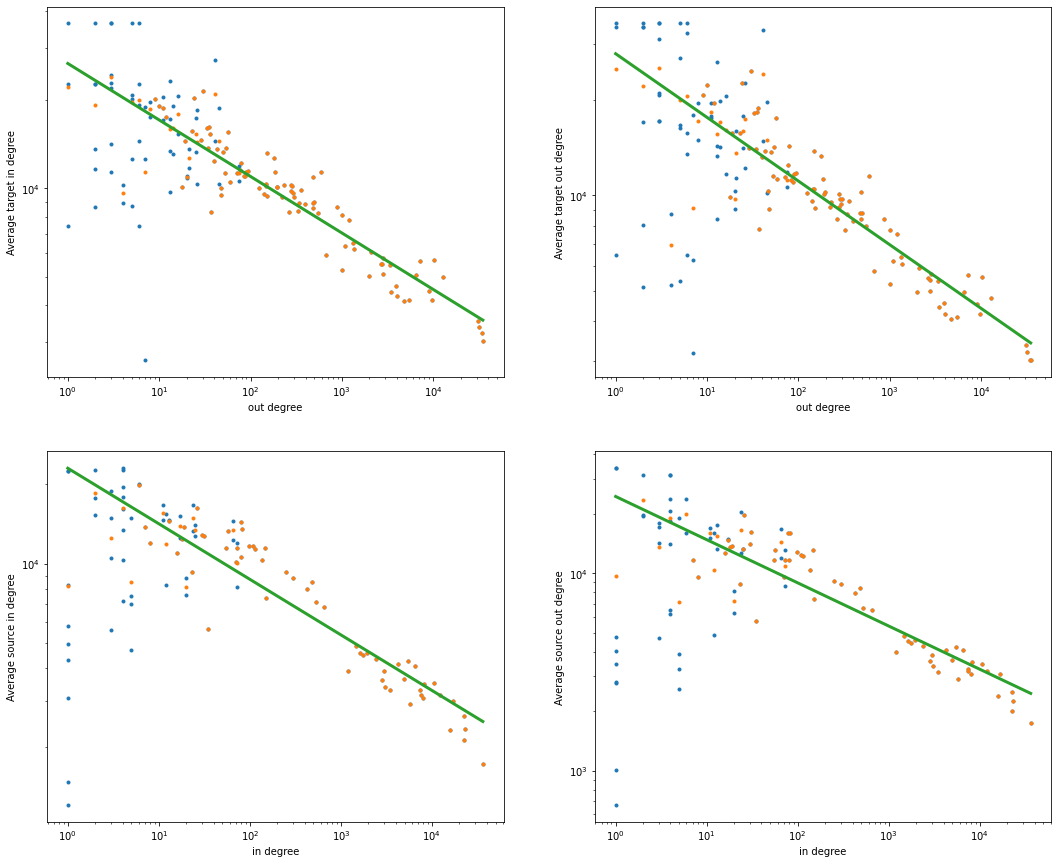

(-0.19190430299796604, -0.201005823903545, -0.2114176952655288, -0.21856149732297478)


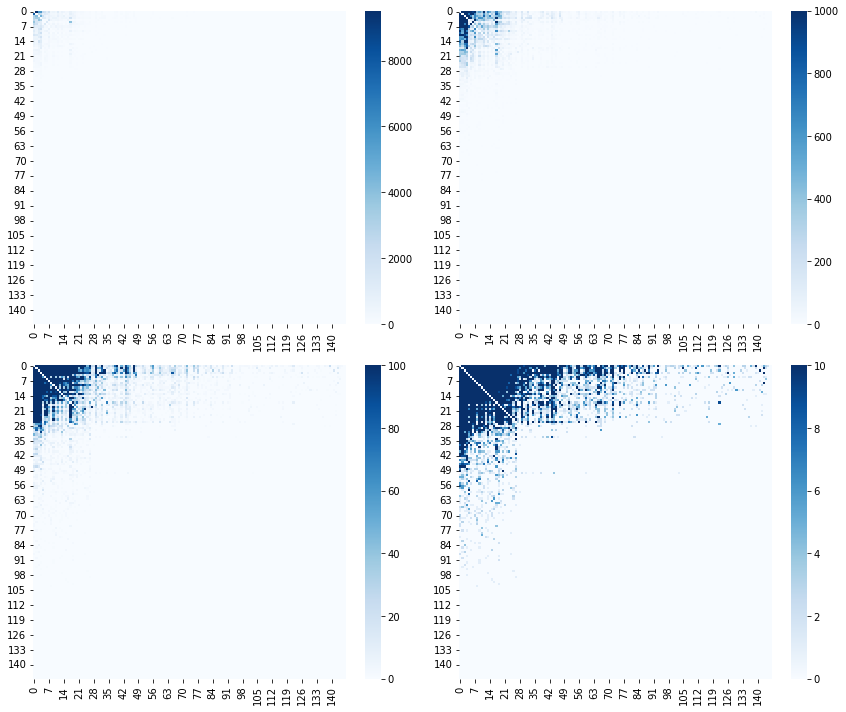

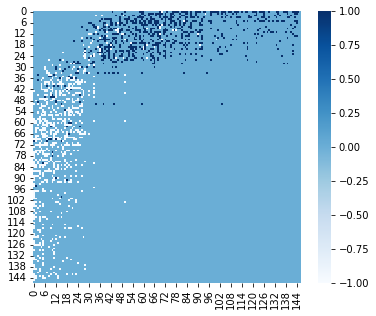

In [3]:
country19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country19_df)

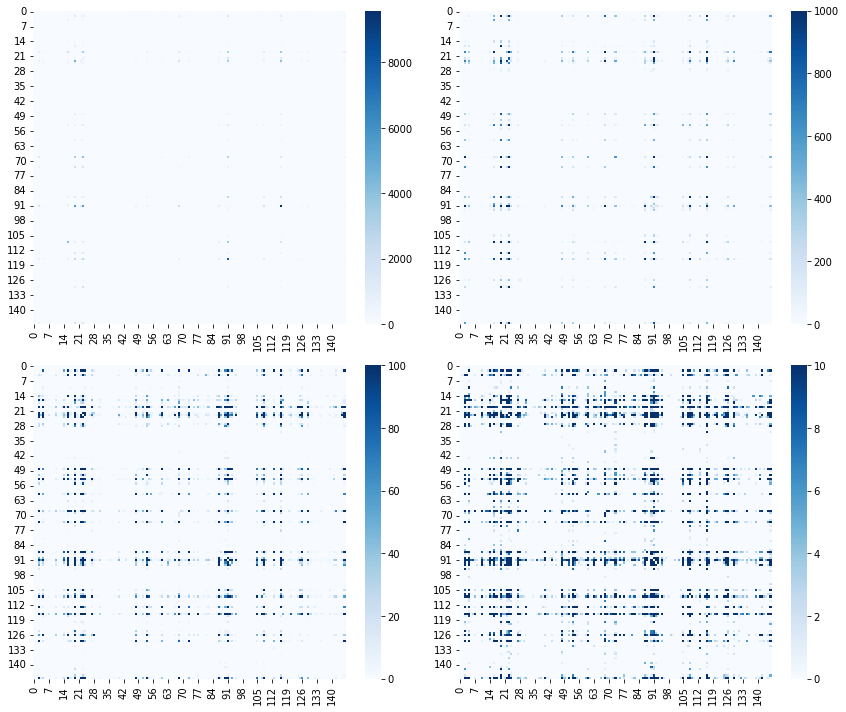

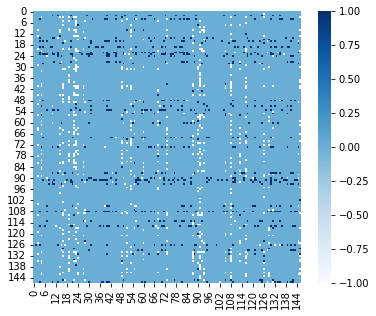

Number of components = 2


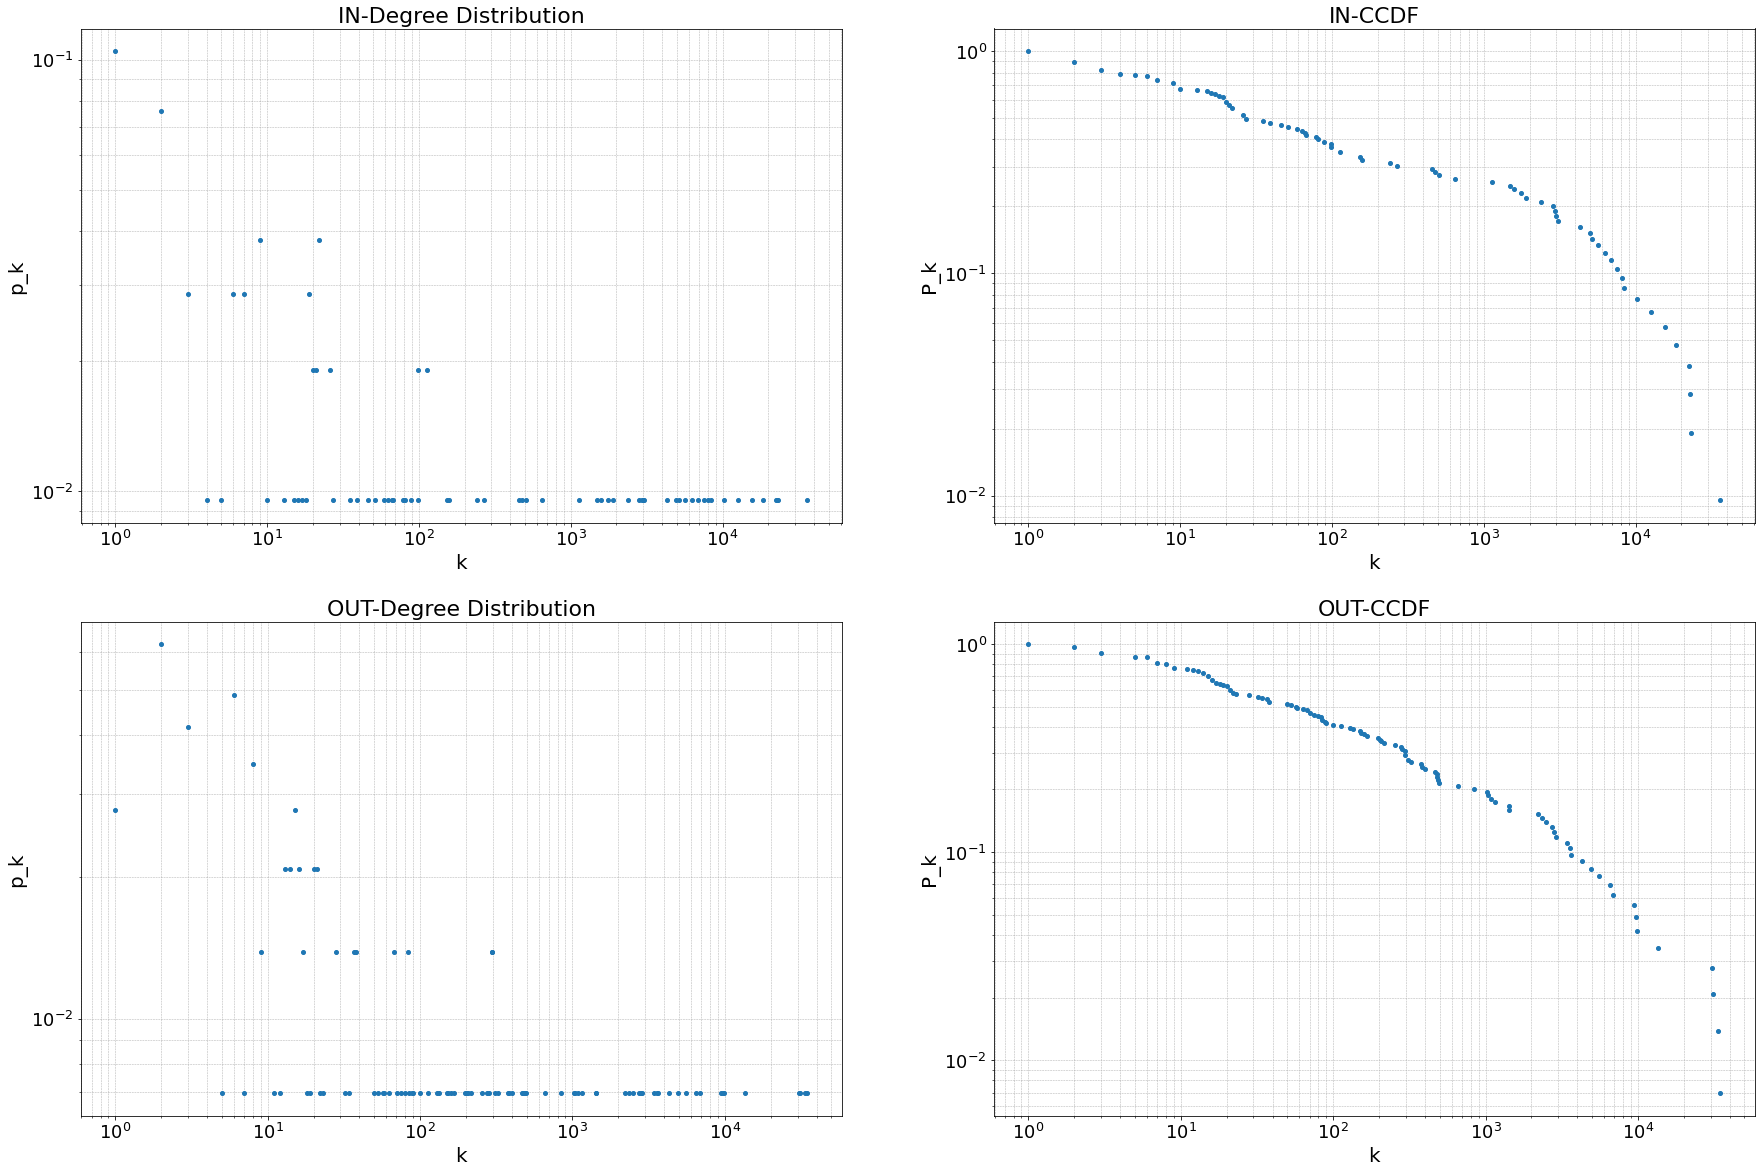

Top 10 for in degree


Nodes  in degree
91         Spain      36020
23        France      23047
19       Germany      22906
116        Italy      22627
68            UK      18474
108       Poland      15539
87      Portugal      12585
2    Netherlands      10198
53       Czechia       8342
73        Sweden       8079

Top 10 for out degree


Nodes  out degree
91         Spain       34630
19       Germany       33780
116        Italy       30947
23        France       30554
16        Turkey       13510
2    Netherlands        9843
108       Poland        9775
68            UK        9395
87      Portugal        6862
22       Belgium        6511

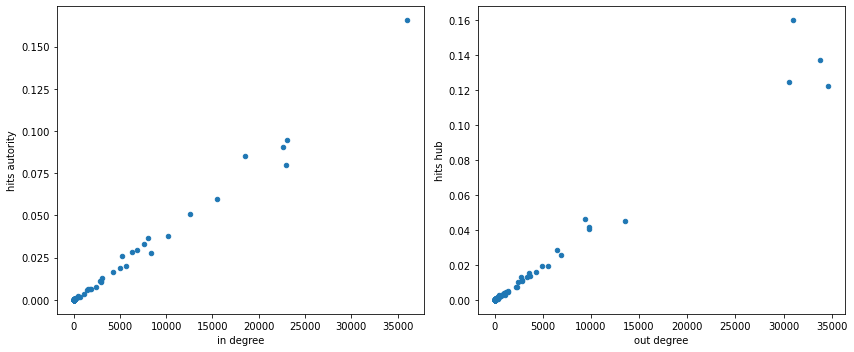

Top 10 for hits hub


Nodes  hits hub
116        Italy  0.160041
19       Germany  0.137508
23        France  0.124890
91         Spain  0.122369
68            UK  0.046538
16        Turkey  0.045017
2    Netherlands  0.041869
108       Poland  0.040729
22       Belgium  0.028681
87      Portugal  0.025886

Top 10 for hits autority


Nodes  hits autority
91         Spain       0.165548
23        France       0.094907
116        Italy       0.090780
68            UK       0.085221
19       Germany       0.079958
108       Poland       0.059830
87      Portugal       0.050634
2    Netherlands       0.037921
73        Sweden       0.036803
146      Finland       0.033260

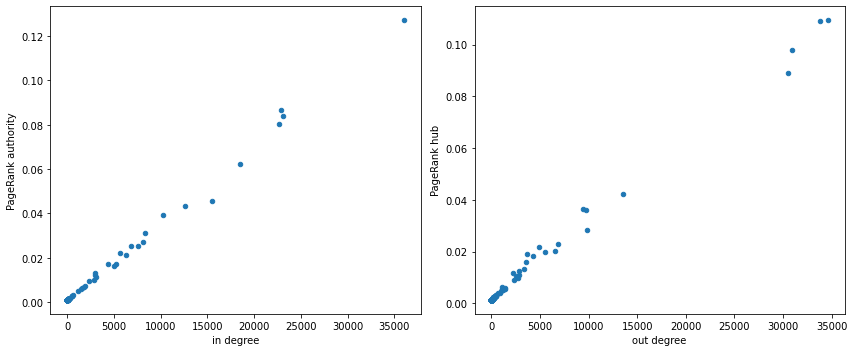

Top 10 for PageRank hub


Nodes  PageRank hub
91         Spain      0.109364
19       Germany      0.109099
116        Italy      0.097924
23        France      0.089084
16        Turkey      0.042240
68            UK      0.036373
108       Poland      0.036089
2    Netherlands      0.028372
87      Portugal      0.023053
48       Austria      0.021770

Top 10 for PageRank authority


Nodes  PageRank authority
91         Spain            0.127053
19       Germany            0.086534
23        France            0.083933
116        Italy            0.080115
68            UK            0.062336
108       Poland            0.045379
87      Portugal            0.043211
2    Netherlands            0.039211
53       Czechia            0.031170
73        Sweden            0.027315

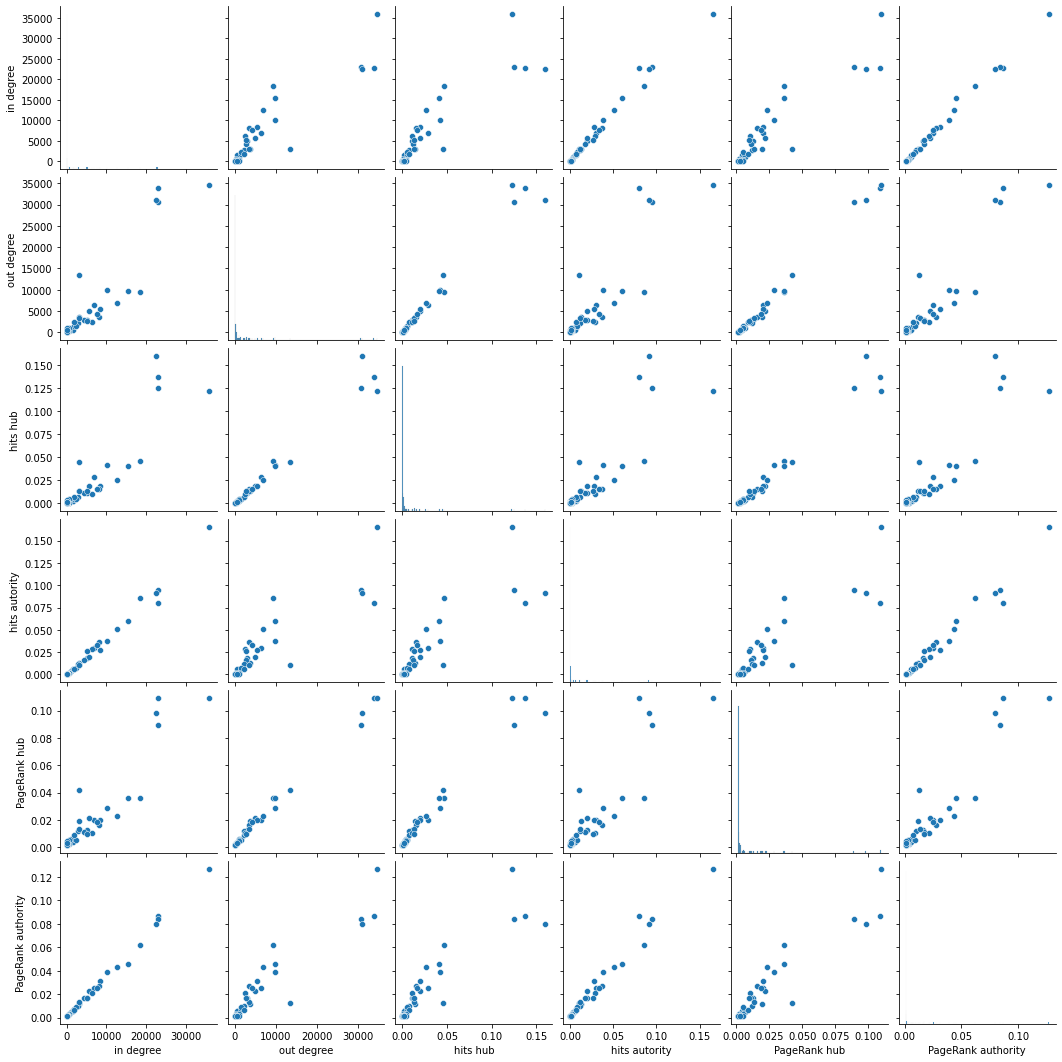

Nodes  in degree  in degree position  hits autority  \
91                    Spain      36020                   1       0.165548   
19                  Germany      22906                   3       0.079958   
23                   France      23047                   2       0.094907   
116                   Italy      22627                   4       0.090780   
68                       UK      18474                   5       0.085221   
108                  Poland      15539                   6       0.059830   
87                 Portugal      12585                   7       0.050634   
2               Netherlands      10198                   8       0.037921   
53                  Czechia       8342                   9       0.027543   
73                   Sweden       8079                  10       0.036803   
146                 Finland       7590                  11       0.033260   
22                  Belgium       6846                  12       0.029684   
48                  Austria       5666                  14       0.019946   
113                  Norway       6282                  13       0.028431   
129                 Ireland       5184                  15       0.025973   
60                  Denmark       4315                  17       0.016555   
24                  Hungary       4970                  16       0.018853   
126                      EL       3001                  19       0.010903   
16                   Turkey       2952                  20       0.010592   
4                   Romania       3058                  18       0.012703   
90                Lithuania       2835                  21       0.011192   
93                 Slovenia       2378                  22       0.007568   
92                  Croatia       1909                  23       0.006136   
105                Slovakia       1763                  24       0.006463   
14                   Latvia       1587                  25       0.006606   
51                  Estonia       1479                  26       0.005960   
27                 Bulgaria       1129                  27       0.003655   
28                   Cyprus        650                  28       0.001940   
55                  Iceland        510                  29       0.002093   
17                    Malta        453                  31       0.001687   
107      Russian Federation        475                  30       0.001612   
124                  Israel        268                  32       0.000985   
54                   Serbia        242                  33       0.000875   
69            United States        157                  34       0.000696   
145              Luxembourg        152                  35       0.000693   
117  Bosnia and Herzegovina        113                  37       0.000367   
10                    China         79                  43       0.000147   
120                  Canada         89                  41       0.000308   
125                 Ukraine         98                  40       0.000297   
63          North Macedonia        113                  36       0.000405   

     hits autority position  PageRank authority  PageRank authority position  
91                        1            0.127053                            1  
19                        5            0.086534                            2  
23                        2            0.083933                            3  
116                       3            0.080115                            4  
68                        4            0.062336                            5  
108                       6            0.045379                            6  
87                        7            0.043211                            7  
2                         8            0.039211                            8  
53                       13            0.031170                            9  
73                        9            0.027315                           

Nodes  out degree  out degree position  hits hub  \
91                    Spain       34630                    1  0.122369   
19                  Germany       33780                    2  0.137508   
116                   Italy       30947                    3  0.160041   
23                   France       30554                    4  0.124890   
16                   Turkey       13510                    5  0.045017   
68                       UK        9395                    8  0.046538   
108                  Poland        9775                    7  0.040729   
2               Netherlands        9843                    6  0.041869   
87                 Portugal        6862                    9  0.025886   
48                  Austria        4938                   12  0.019161   
22                  Belgium        6511                   10  0.028681   
53                  Czechia        5527                   11  0.019247   
4                   Romania        3646                   14  0.013879   
146                 Finland        4275                   13  0.016044   
73                   Sweden        3574                   15  0.015303   
126                      EL        3404                   16  0.013223   
24                  Hungary        2882                   17  0.010898   
90                Lithuania        2205                   22  0.007061   
60                  Denmark        2811                   18  0.011598   
113                  Norway        2481                   20  0.010131   
129                 Ireland        2736                   19  0.013247   
105                Slovakia        2345                   21  0.007096   
27                 Bulgaria        1085                   26  0.003823   
92                  Croatia        1435                   23  0.005140   
14                   Latvia        1041                   27  0.002953   
93                 Slovenia        1423                   24  0.004711   
107      Russian Federation        1158                   25  0.004444   
125                 Ukraine        1026                   28  0.003747   
51                  Estonia         660                   30  0.002223   
54                   Serbia         839                   29  0.003316   
117  Bosnia and Herzegovina         477                   34  0.001881   
95                  Morocco         489                   32  0.002320   
145              Luxembourg         495                   31  0.002038   
66                  Tunisia         483                   33  0.002575   
77                  Albania         403                   36  0.001405   
88                  Georgia         465                   35  0.001763   
63          North Macedonia         323                   39  0.000654   
124                  Israel         375                   38  0.001396   
10                    China         382                   37  0.001375   
86                       XK         277                   46  0.000855   

     hits hub position  PageRank hub  PageRank hub position  
91                   4      0.109364                      1  
19                   2      0.109099                      2  
116                  1      0.097924                      3  
23                   3      0.089084                      4  
16                   6      0.042240                      5  
68                   5      0.036373                      6  
108                  8      0.036089                      7  
2                    7      0.028372                      8  
87                  10      0.023053                      9  
48                  12      0.021770                     10  
22                   9      0.020250                     11  
53                  11      0.019907                     12  
4                   15      0.019066                     13  
146                 13      0.018470                     14  
73                  14      0.016030                     

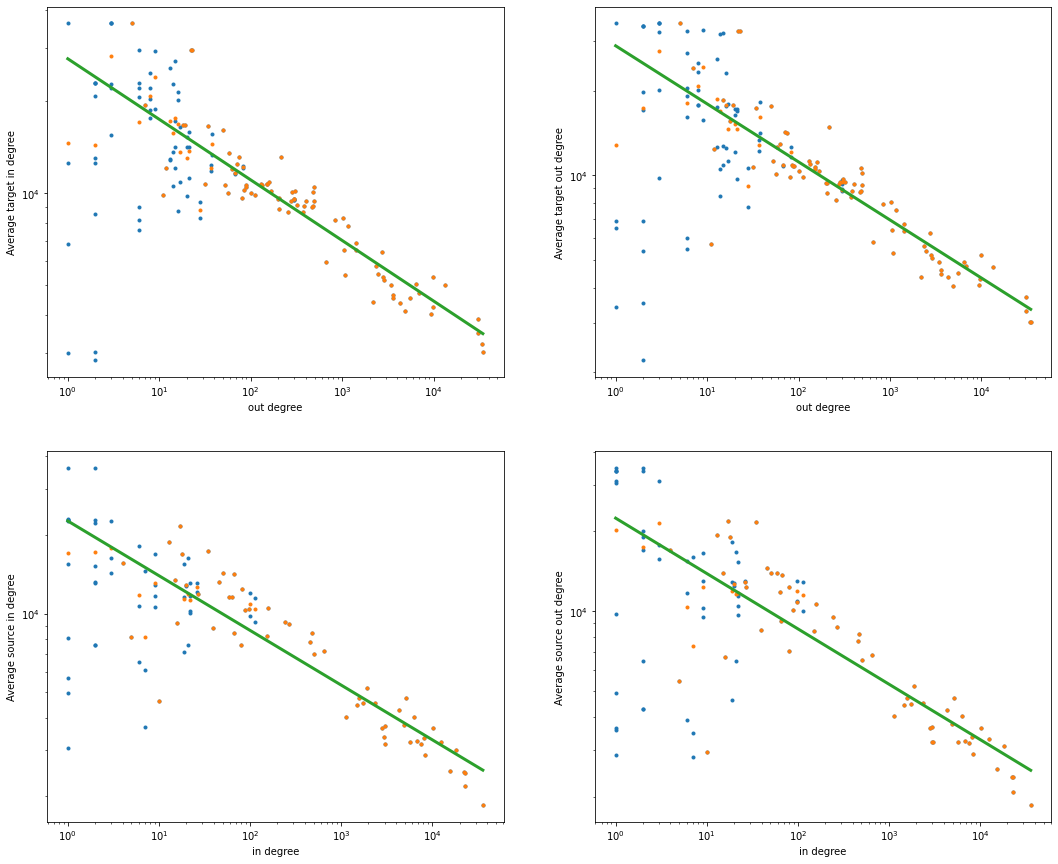

(-0.19839347404635532, -0.20604484181819913, -0.20917415960303473, -0.20856165223470094)


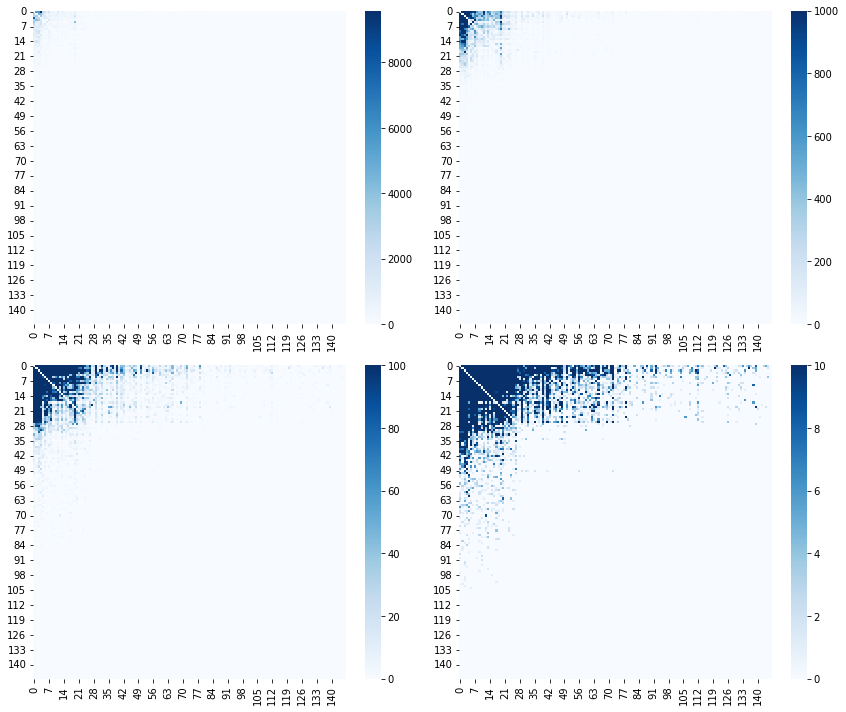

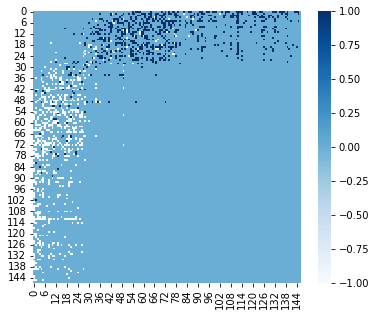

In [4]:
country18_df = pd.read_csv('data\Erasmus18.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country18_df)

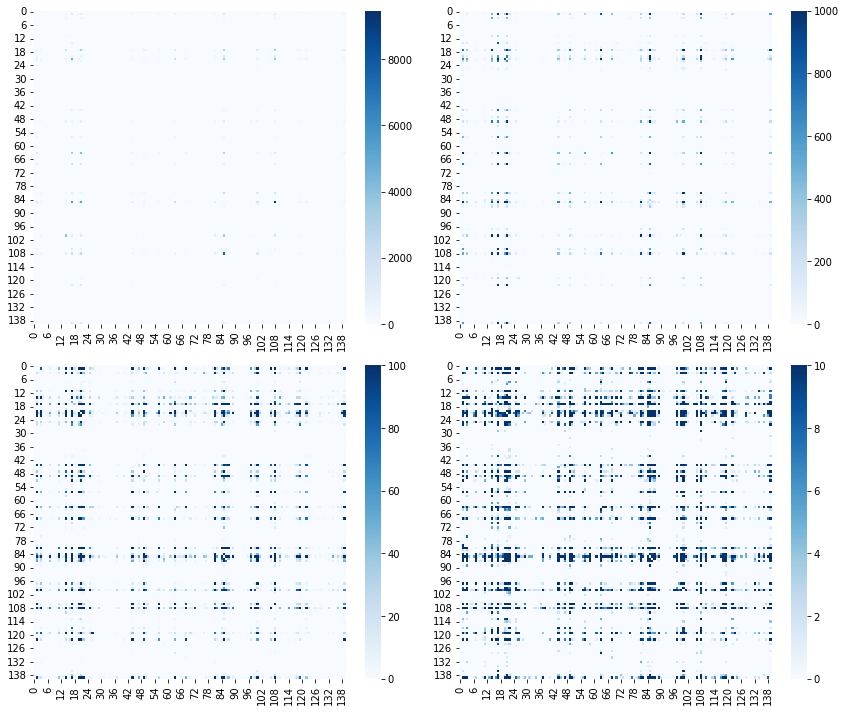

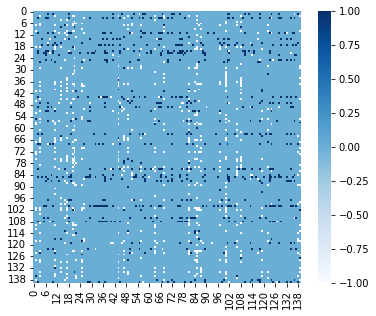

Number of components = 2


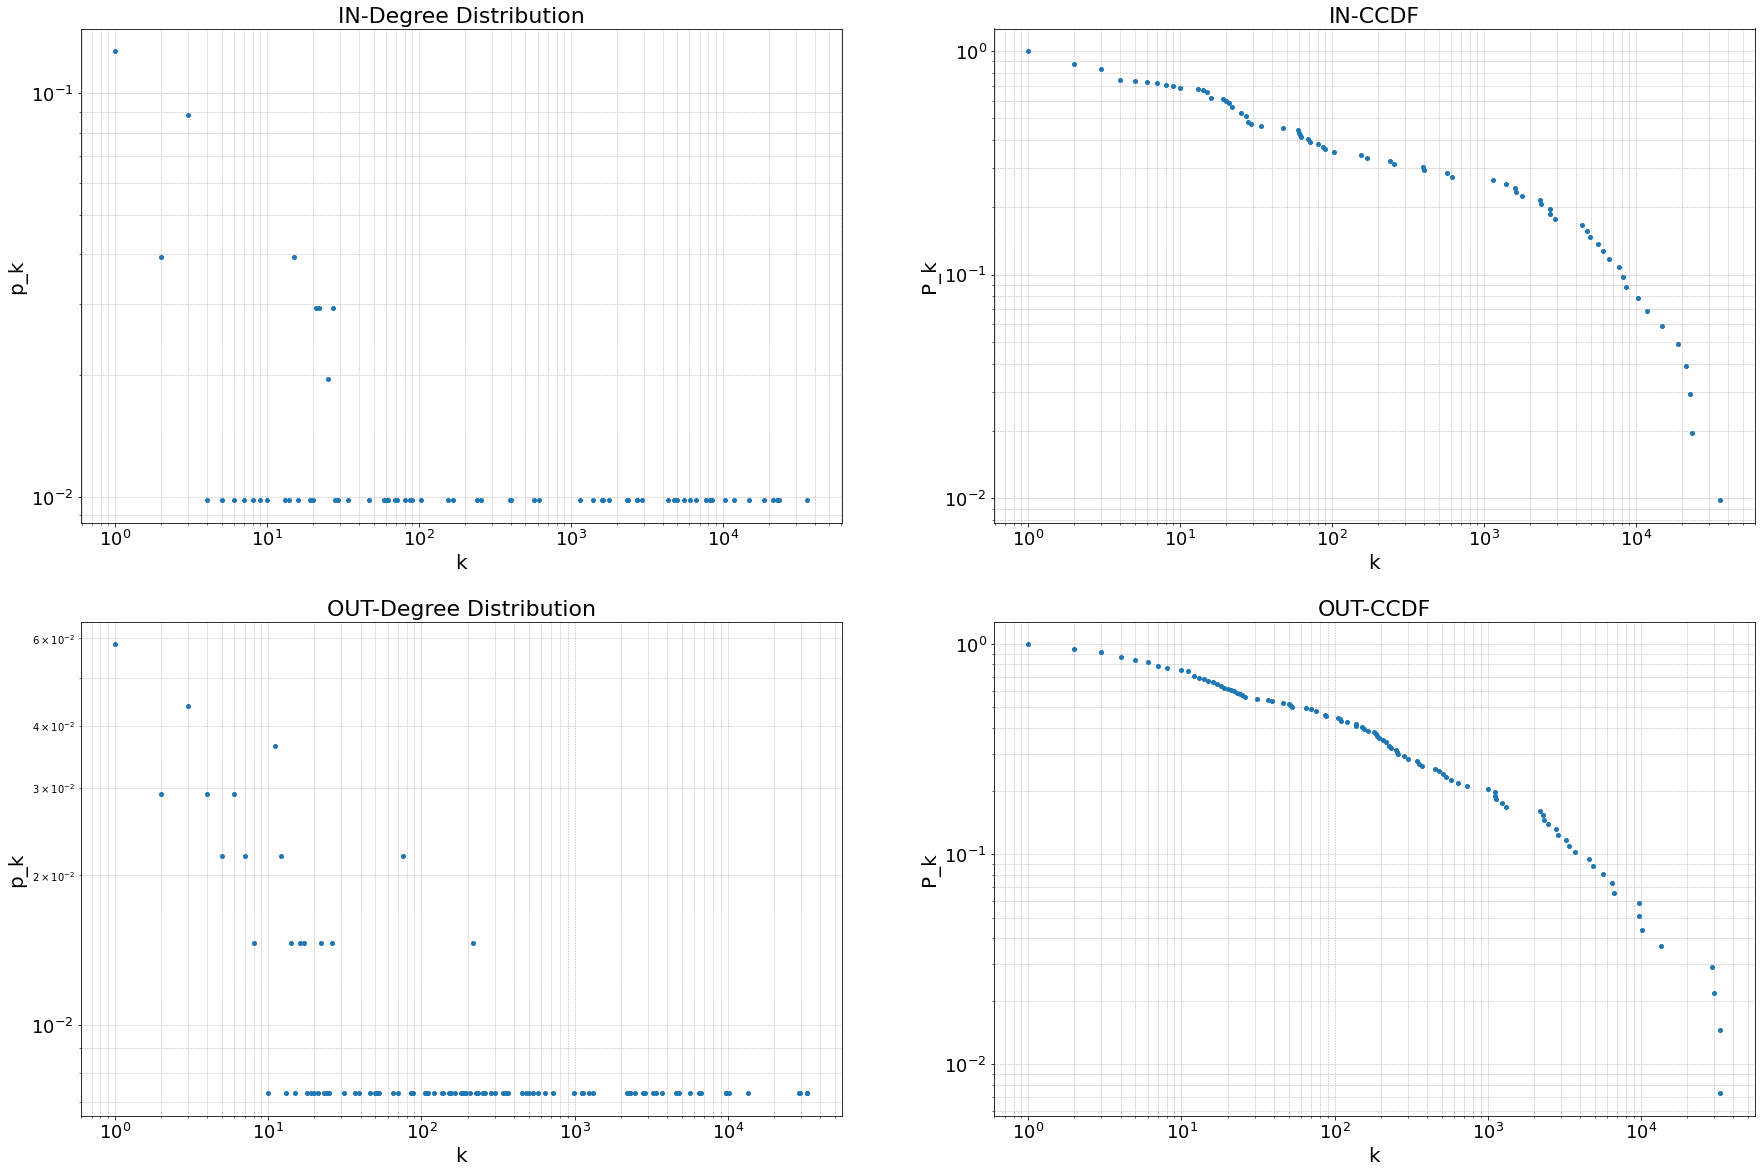

Top 10 for in degree


Nodes  in degree
85         Spain      35605
17       Germany      23161
21        France      22577
108        Italy      21364
63            UK      18668
100       Poland      14837
81      Portugal      11764
1    Netherlands      10325
68        Sweden       8497
49       Czechia       8191

Top 10 for out degree


Nodes  out degree
85         Spain       32975
17       Germany       32916
21        France       29867
108        Italy       29261
14        Turkey       13546
100       Poland       10157
1    Netherlands        9806
63            UK        9681
20       Belgium        6723
81      Portugal        6520

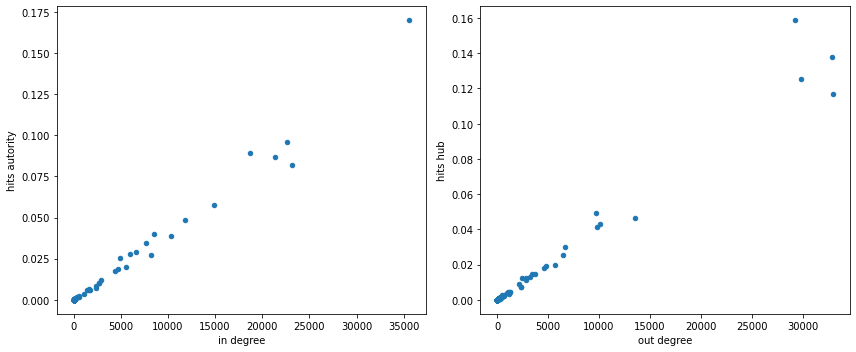

Top 10 for hits hub


Nodes  hits hub
108        Italy  0.158669
17       Germany  0.138050
21        France  0.125551
85         Spain  0.117020
63            UK  0.049037
14        Turkey  0.046440
100       Poland  0.042947
1    Netherlands  0.041421
20       Belgium  0.030267
81      Portugal  0.025288

Top 10 for hits autority


Nodes  hits autority
85         Spain       0.169761
21        France       0.095757
63            UK       0.088944
108        Italy       0.086551
17       Germany       0.082129
100       Poland       0.057782
81      Portugal       0.048229
68        Sweden       0.040013
1    Netherlands       0.039021
139      Finland       0.034659

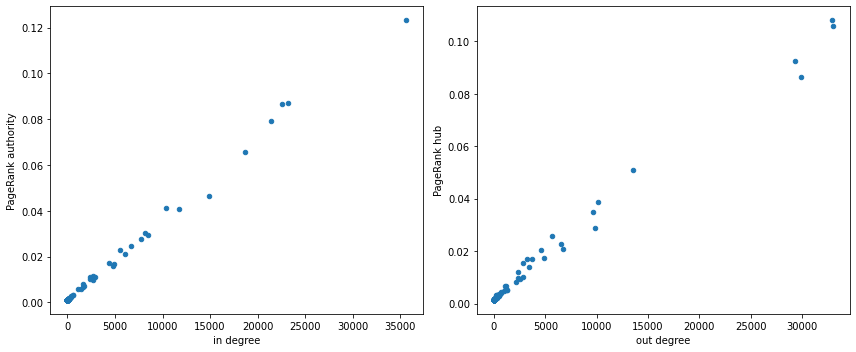

Top 10 for PageRank hub


Nodes  PageRank hub
17       Germany      0.107969
85         Spain      0.105780
108        Italy      0.092630
21        France      0.086511
14        Turkey      0.050982
100       Poland      0.038558
63            UK      0.034877
1    Netherlands      0.028793
49       Czechia      0.025774
81      Portugal      0.022677

Top 10 for PageRank authority


Nodes  PageRank authority
85         Spain            0.123114
17       Germany            0.087006
21        France            0.086449
108        Italy            0.079213
63            UK            0.065609
100       Poland            0.046248
1    Netherlands            0.041350
81      Portugal            0.040707
49       Czechia            0.030310
68        Sweden            0.029418

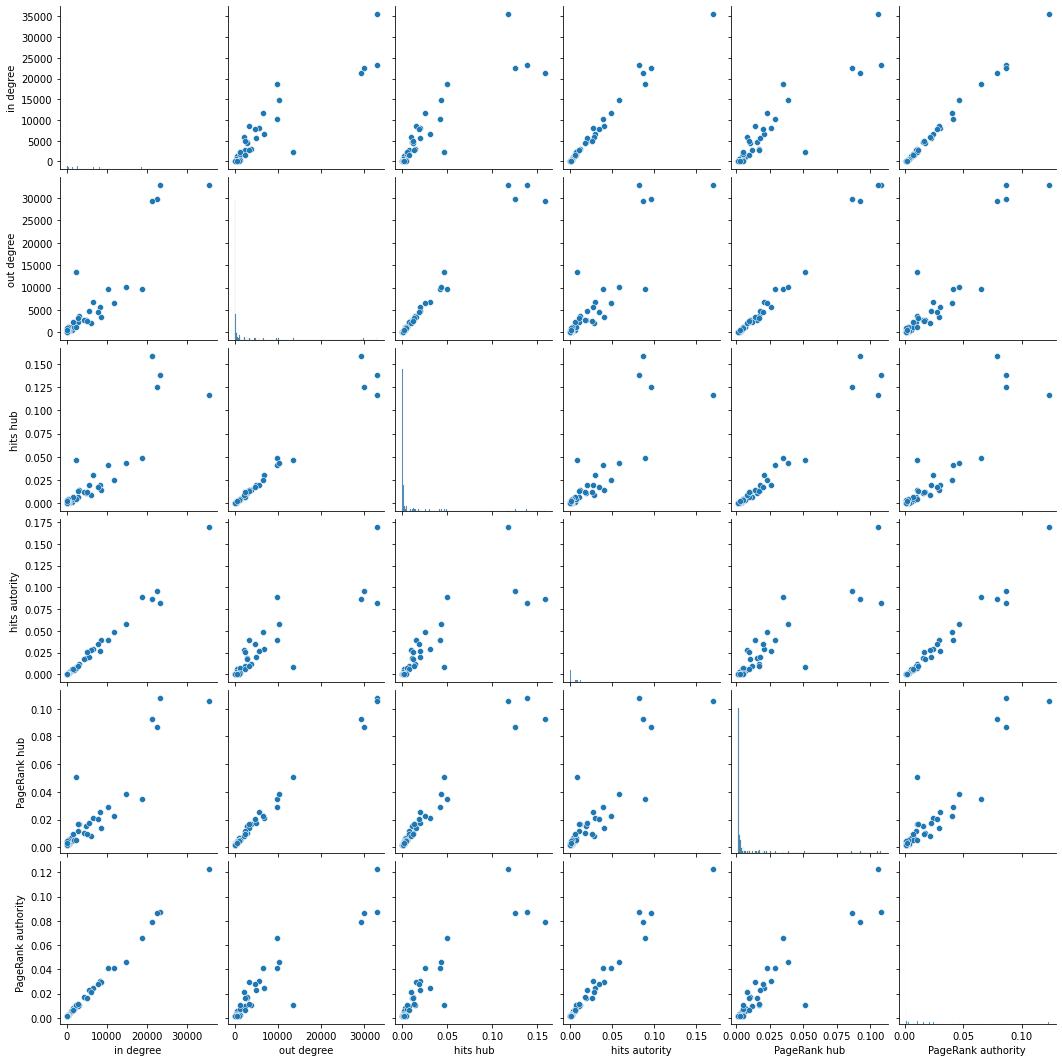

Nodes  in degree  in degree position  hits autority  \
85                Spain      35605                   1       0.169761   
17              Germany      23161                   2       0.082129   
21               France      22577                   3       0.095757   
108               Italy      21364                   4       0.086551   
63                   UK      18668                   5       0.088944   
100              Poland      14837                   6       0.057782   
1           Netherlands      10325                   8       0.039021   
81             Portugal      11764                   7       0.048229   
49              Czechia       8191                  10       0.027478   
68               Sweden       8497                   9       0.040013   
139             Finland       7719                  11       0.034659   
20              Belgium       6645                  12       0.029181   
44              Austria       5562                  14       0.020000   
106              Norway       6012                  13       0.027800   
56              Denmark       4362                  17       0.017367   
122             Ireland       4942                  15       0.025519   
22              Hungary       4753                  16       0.018594   
119                  EL       2688                  20       0.009944   
3               Romania       2932                  18       0.011985   
14               Turkey       2326                  22       0.008511   
87             Slovenia       2367                  21       0.007317   
84            Lithuania       2692                  19       0.010274   
11               Latvia       1593                  25       0.006580   
86              Croatia       1777                  23       0.005673   
97             Slovakia       1627                  24       0.006065   
47              Estonia       1397                  26       0.005867   
25             Bulgaria       1142                  27       0.003644   
51              Iceland        569                  29       0.002494   
26               Cyprus        614                  28       0.001771   
16                Malta        395                  31       0.001552   
99   Russian Federation        403                  30       0.001586   
117              Israel        240                  33       0.000845   
50               Serbia        253                  32       0.000888   
64        United States        168                  34       0.000569   
138          Luxembourg        154                  35       0.000767   
7                 China         87                  38       0.000229   
113              Canada        102                  36       0.000447   
13                Japan         90                  37       0.000415   
40   Korea, Republic of         59                  45       0.000186   
72              Albania         71                  40       0.000381   

     hits autority position  PageRank authority  PageRank authority position  
85                        1            0.123114                            1  
17                        5            0.087006                            2  
21                        2            0.086449                            3  
108                       4            0.079213                            4  
63                        3            0.065609                            5  
100                       6            0.046248                            6  
1                         9            0.041350                            7  
81                        7            0.040707                            8  
49                       13            0.030310                            9  
68                        8            0.029418                           10  
139                      10            0.027783                           11  
20                       11            0.024593                           12

Nodes  out degree  out degree position  hits hub  \
17                  Germany       32916                    2  0.138050   
85                    Spain       32975                    1  0.117020   
108                   Italy       29261                    4  0.158669   
21                   France       29867                    3  0.125551   
14                   Turkey       13546                    5  0.046440   
100                  Poland       10157                    6  0.042947   
63                       UK        9681                    8  0.049037   
1               Netherlands        9806                    7  0.041421   
49                  Czechia        5694                   11  0.019911   
81                 Portugal        6520                   10  0.025288   
20                  Belgium        6723                    9  0.030267   
139                 Finland        4613                   13  0.018064   
44                  Austria        4838                   12  0.019445   
3                   Romania        3701                   14  0.014400   
119                      EL        3268                   16  0.013178   
22                  Hungary        2869                   17  0.011019   
68                   Sweden        3394                   15  0.014861   
84                Lithuania        2309                   21  0.007263   
56                  Denmark        2810                   18  0.012119   
97                 Slovakia        2316                   20  0.007171   
122                 Ireland        2492                   19  0.012187   
106                  Norway        2196                   22  0.009252   
25                 Bulgaria        1112                   27  0.003873   
11                   Latvia        1141                   25  0.003331   
87                 Slovenia        1311                   23  0.004607   
86                  Croatia        1233                   24  0.004574   
99       Russian Federation        1122                   26  0.004397   
118                 Ukraine         998                   28  0.004001   
47                  Estonia         643                   30  0.002034   
50                   Serbia         728                   29  0.002768   
110  Bosnia and Herzegovina         450                   35  0.001515   
7                     China         575                   31  0.002390   
89                  Morocco         537                   32  0.002809   
82                  Georgia         507                   33  0.001899   
58          North Macedonia         303                   39  0.000562   
70                   Jordan         259                   41  0.000759   
19               Azerbaijan         189                   50  0.000450   
138              Luxembourg         484                   34  0.002201   
61                  Tunisia         357                   37  0.001660   
72                  Albania         370                   36  0.001528   

     hits hub position  PageRank hub  PageRank hub position  
17                   2      0.107969                      1  
85                   4      0.105780                      2  
108                  1      0.092630                      3  
21                   3      0.086511                      4  
14                   6      0.050982                      5  
100                  7      0.038558                      6  
63                   5      0.034877                      7  
1                    8      0.028793                      8  
49                  11      0.025774                      9  
81                  10      0.022677                     10  
20                   9      0.020963                     11  
139                 13      0.020220                     12  
44                  12      0.017531                     13  
3                   15      0.017118                     14  
119                 16      0.016792                     

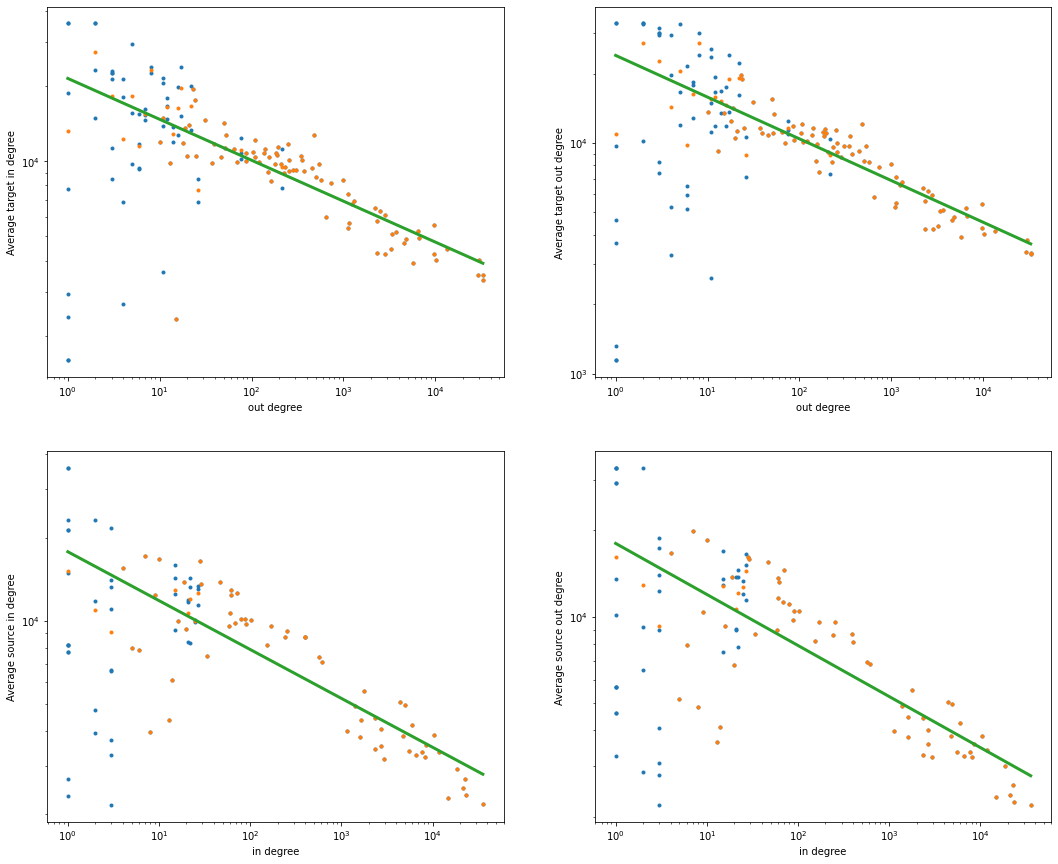

(-0.1638113565743919, -0.1808333579656681, -0.17663416293109127, -0.17836246071891335)


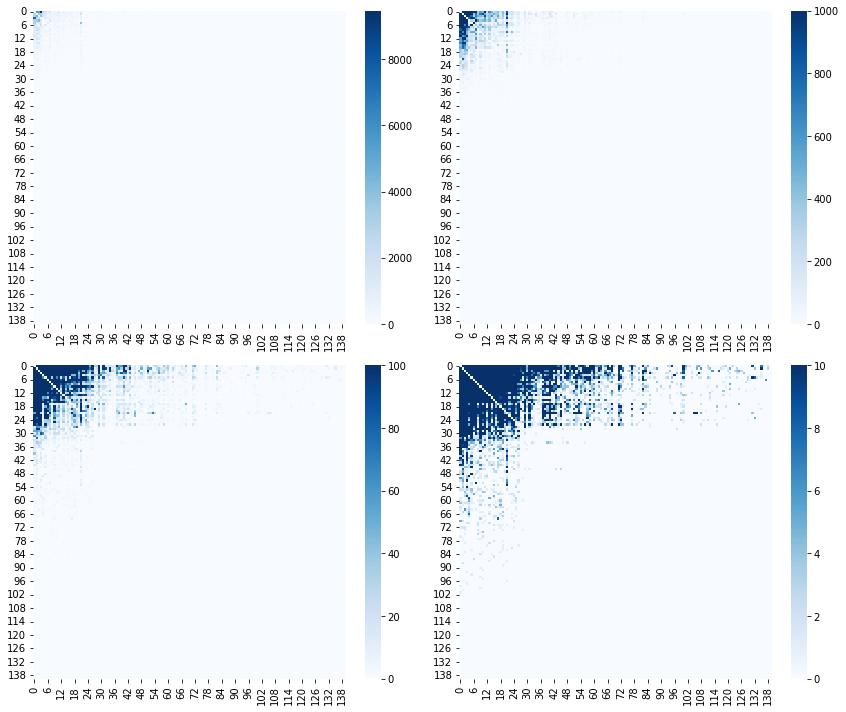

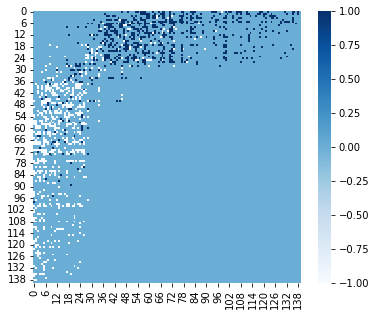

In [5]:
country17_df = pd.read_csv('data\Erasmus17.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country17_df)

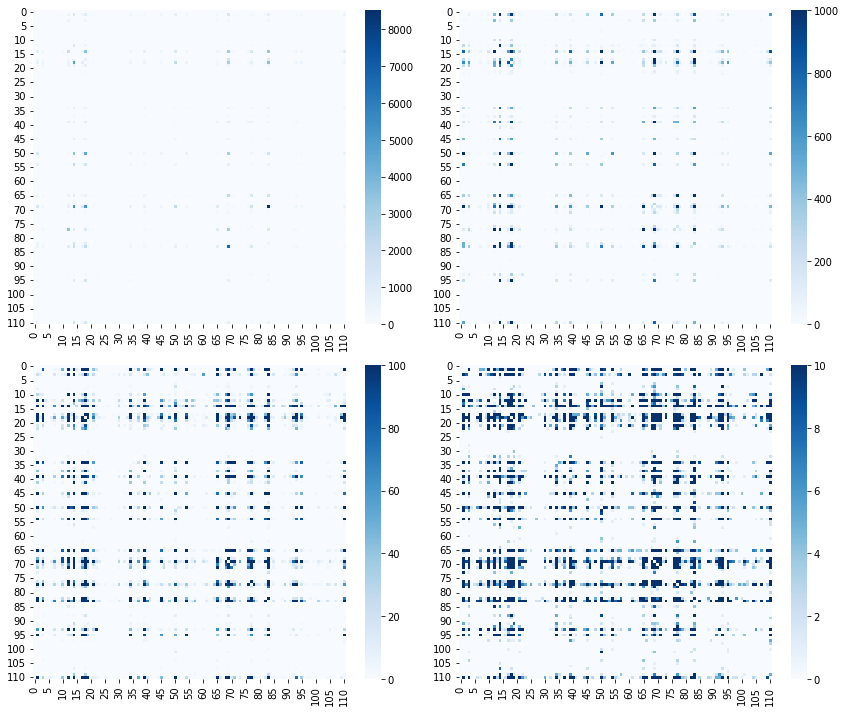

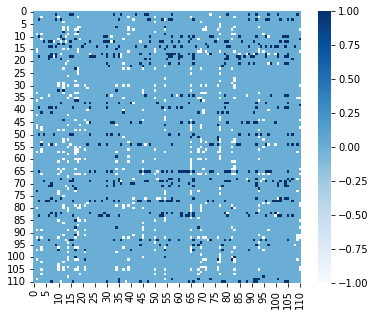

Number of components = 2


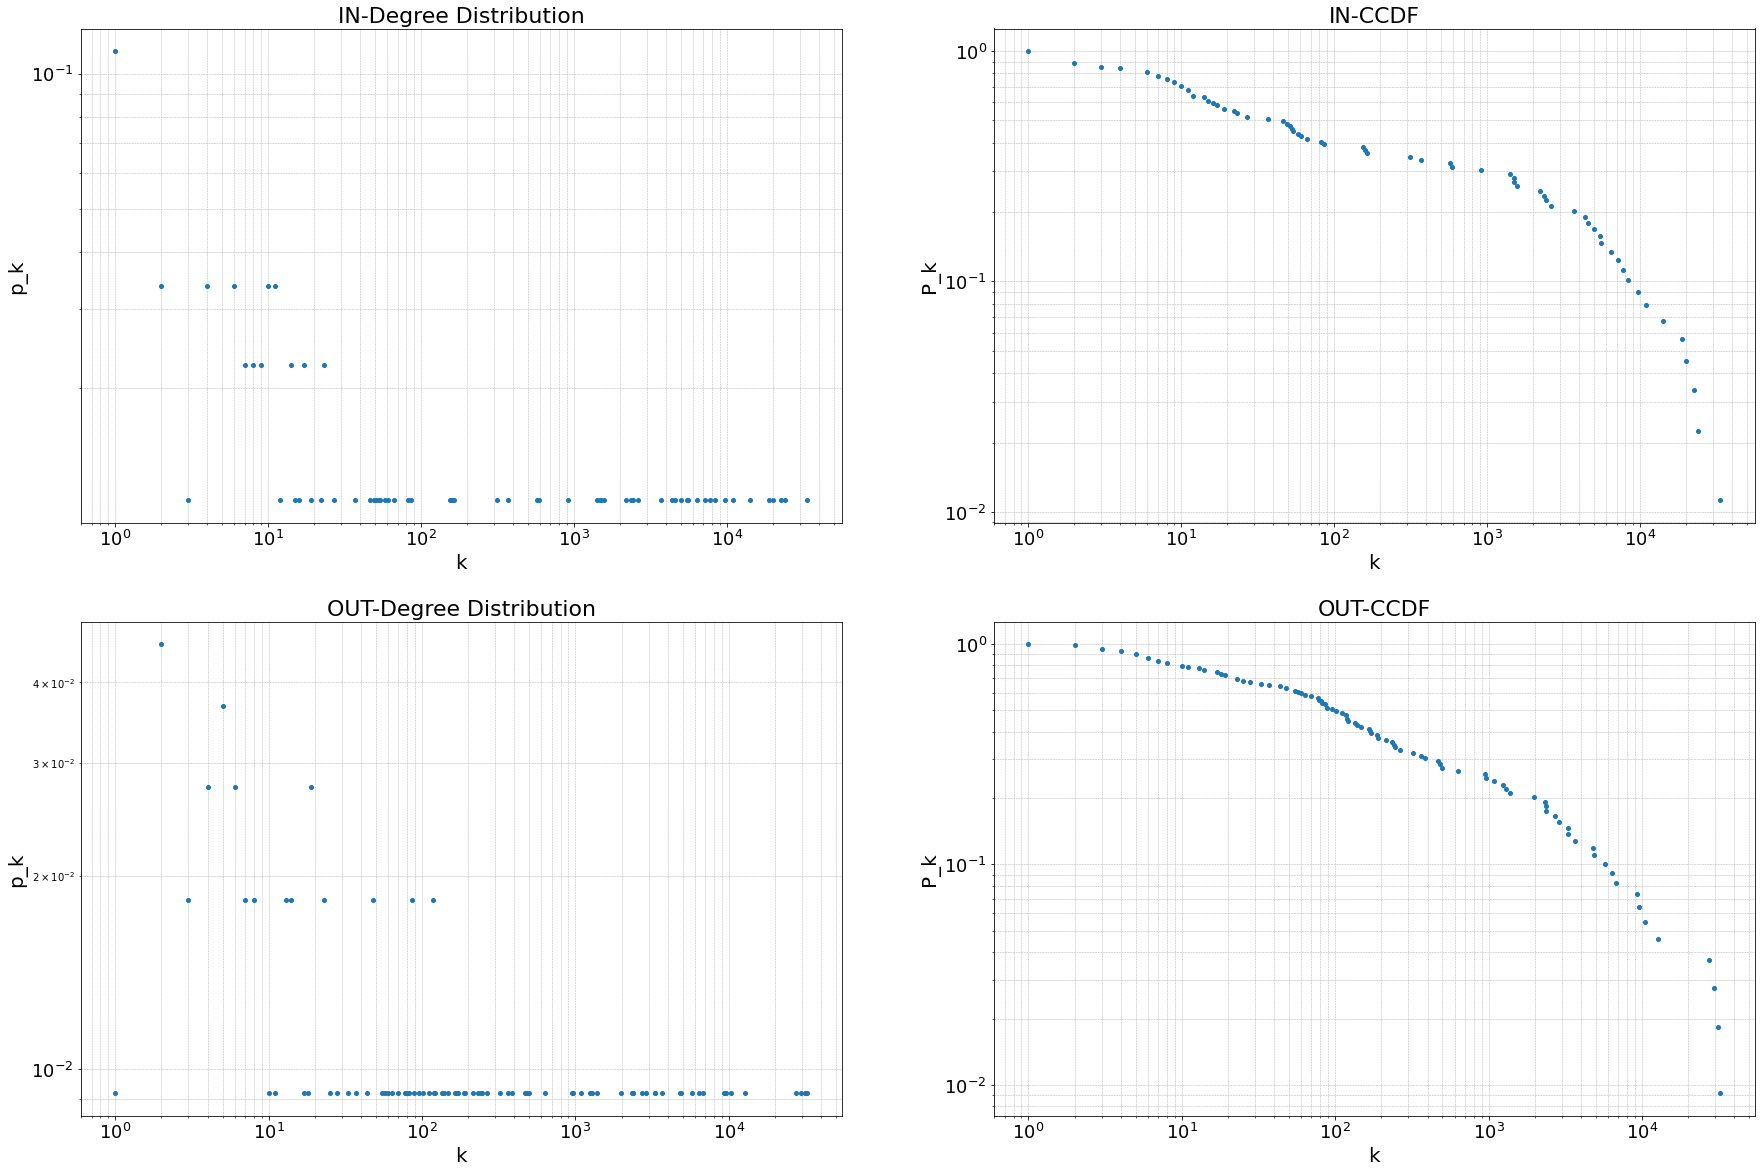

Top 10 for in degree


Nodes  in degree
69        Spain      33293
14      Germany      23798
18       France      22383
83        Italy      19833
50           UK      18794
77       Poland      14105
65     Portugal      10852
1   Netherlands       9731
54       Sweden       8345
39      Czechia       7736

Top 10 for out degree


Nodes  out degree
14      Germany       32334
69        Spain       31506
18       France       29317
83        Italy       27270
12       Turkey       12785
77       Poland       10401
50           UK        9578
1   Netherlands        9319
17      Belgium        6751
65     Portugal        6377

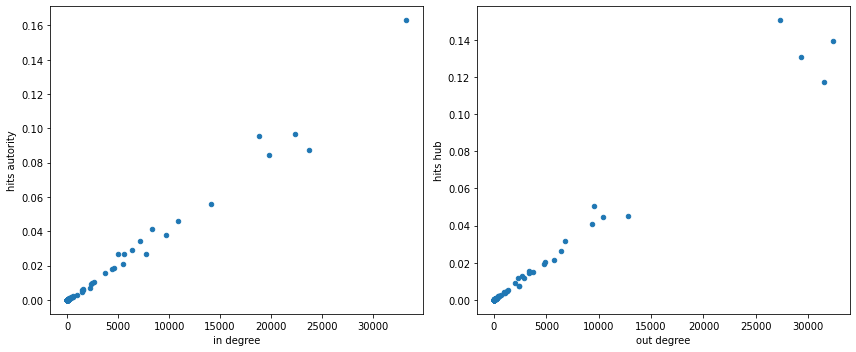

Top 10 for hits hub


Nodes  hits hub
83        Italy  0.150597
14      Germany  0.139633
18       France  0.131016
69        Spain  0.117437
50           UK  0.050395
12       Turkey  0.045201
77       Poland  0.044641
1   Netherlands  0.040668
17      Belgium  0.031715
65     Portugal  0.026263

Top 10 for hits autority


Nodes  hits autority
69         Spain       0.162945
18        France       0.096727
50            UK       0.095482
14       Germany       0.087375
83         Italy       0.084303
77        Poland       0.055721
65      Portugal       0.045732
54        Sweden       0.041256
1    Netherlands       0.038033
110      Finland       0.034068

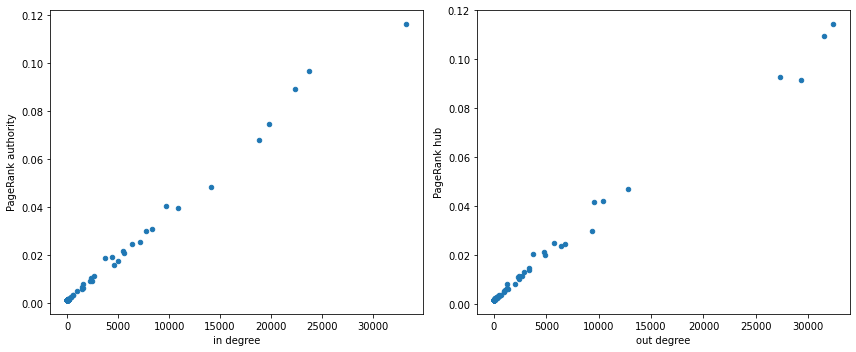

Top 10 for PageRank hub


Nodes  PageRank hub
14      Germany      0.114569
69        Spain      0.109729
83        Italy      0.092845
18       France      0.091482
12       Turkey      0.046980
77       Poland      0.042238
50           UK      0.041662
1   Netherlands      0.029906
39      Czechia      0.024756
17      Belgium      0.024384

Top 10 for PageRank authority


Nodes  PageRank authority
69        Spain            0.116533
14      Germany            0.096689
18       France            0.089403
83        Italy            0.074795
50           UK            0.068275
77       Poland            0.048501
1   Netherlands            0.040407
65     Portugal            0.039777
54       Sweden            0.030819
39      Czechia            0.029999

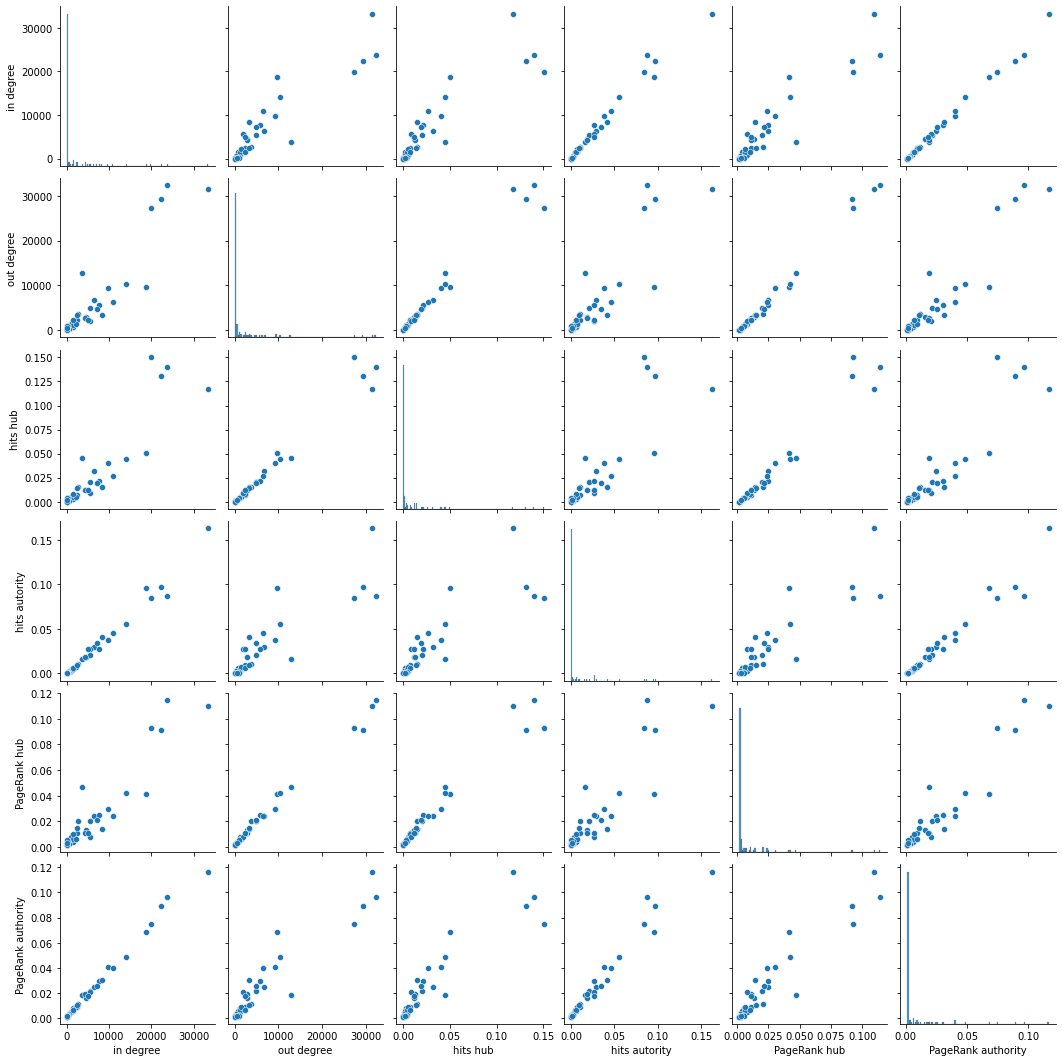

Nodes  in degree  in degree position  hits autority  \
69                Spain      33293                   1       0.162945   
14              Germany      23798                   2       0.087375   
18               France      22383                   3       0.096727   
83                Italy      19833                   4       0.084303   
50                   UK      18794                   5       0.095482   
77               Poland      14105                   6       0.055721   
1           Netherlands       9731                   8       0.038033   
65             Portugal      10852                   7       0.045732   
54               Sweden       8345                   9       0.041256   
39              Czechia       7736                  10       0.026969   
110             Finland       7179                  11       0.034068   
17              Belgium       6395                  12       0.029199   
34              Austria       5428                  14       0.020758   
82               Norway       5532                  13       0.026885   
45              Denmark       4341                  17       0.017851   
12               Turkey       3693                  18       0.015895   
95              Ireland       4999                  15       0.026967   
19              Hungary       4542                  16       0.018515   
3               Romania       2625                  19       0.010639   
93                   EL       2353                  21       0.008945   
71             Slovenia       2196                  22       0.006885   
68            Lithuania       2429                  20       0.009774   
10               Latvia       1500                  24       0.006364   
70              Croatia       1485                  25       0.004798   
76             Slovakia       1556                  23       0.005946   
37              Estonia       1408                  26       0.005928   
21             Bulgaria        916                  27       0.003091   
41              Iceland        586                  28       0.002462   
22               Cyprus        570                  29       0.001849   
13                Malta        311                  31       0.001155   
78   Russian Federation        368                  30       0.001684   
51        United States        159                  33       0.000595   
40               Serbia        163                  32       0.000558   
109          Luxembourg        155                  34       0.000800   
91               Israel         82                  36       0.000308   
88               Canada         86                  35       0.000393   
7                 China         66                  37       0.000184   
36            Australia         61                  38       0.000333   
73              Morocco         58                  39       0.000304   
32   Korea, Republic of         49                  43       0.000137   

     hits autority position  PageRank authority  PageRank authority position  
69                        1            0.116533                            1  
14                        4            0.096689                            2  
18                        2            0.089403                            3  
83                        5            0.074795                            4  
50                        3            0.068275                            5  
77                        6            0.048501                            6  
1                         9            0.040407                            7  
65                        7            0.039777                            8  
54                        8            0.030819                            9  
39                       12            0.029999                           10  
110                      10            0.025510                           11  
17                       11            0.024832                           12

Nodes  out degree  out degree position  hits hub  \
14              Germany       32334                    1  0.139633   
69                Spain       31506                    2  0.117437   
83                Italy       27270                    4  0.150597   
18               France       29317                    3  0.131016   
12               Turkey       12785                    5  0.045201   
77               Poland       10401                    6  0.044641   
50                   UK        9578                    7  0.050395   
1           Netherlands        9319                    8  0.040668   
39              Czechia        5721                   11  0.021545   
17              Belgium        6751                    9  0.031715   
65             Portugal        6377                   10  0.026263   
110             Finland        4781                   13  0.019474   
3               Romania        3678                   14  0.014823   
34              Austria        4873                   12  0.020217   
93                   EL        3310                   16  0.014303   
54               Sweden        3319                   15  0.015275   
19              Hungary        2887                   17  0.011807   
68            Lithuania        2359                   20  0.007445   
45              Denmark        2720                   18  0.012691   
95              Ireland        2333                   21  0.011820   
76             Slovakia        2368                   19  0.007646   
82               Norway        1979                   22  0.008815   
21             Bulgaria        1290                   24  0.004872   
70              Croatia        1251                   25  0.004658   
71             Slovenia        1381                   23  0.005118   
10               Latvia        1085                   26  0.003462   
92              Ukraine         945                   28  0.003750   
78   Russian Federation         969                   27  0.004081   
37              Estonia         632                   29  0.002337   
40               Serbia         496                   30  0.001893   
109          Luxembourg         485                   31  0.002327   
7                 China         468                   32  0.002004   
66              Georgia         361                   34  0.001258   
73              Morocco         383                   33  0.001900   
22               Cyprus         321                   35  0.000758   
30           Kazakhstan         247                   37  0.000918   
48              Tunisia         266                   36  0.001248   
46      North Macedonia         191                   41  0.000417   
57              Albania         187                   42  0.000763   
56               Jordan         148                   46  0.000516   

     hits hub position  PageRank hub  PageRank hub position  
14                   2      0.114569                      1  
69                   4      0.109729                      2  
83                   1      0.092845                      3  
18                   3      0.091482                      4  
12                   6      0.046980                      5  
77                   7      0.042238                      6  
50                   5      0.041662                      7  
1                    8      0.029906                      8  
39                  11      0.024756                      9  
17                   9      0.024384                     10  
65                  10      0.023881                     11  
110                 13      0.021154                     12  
3                   15      0.020380                     13  
34                  12      0.020145                     14  
93                  16      0.014628                     15  
54                  14      0.014002                     16  
19                  19      0.013235                     17  
68                  22      0.0

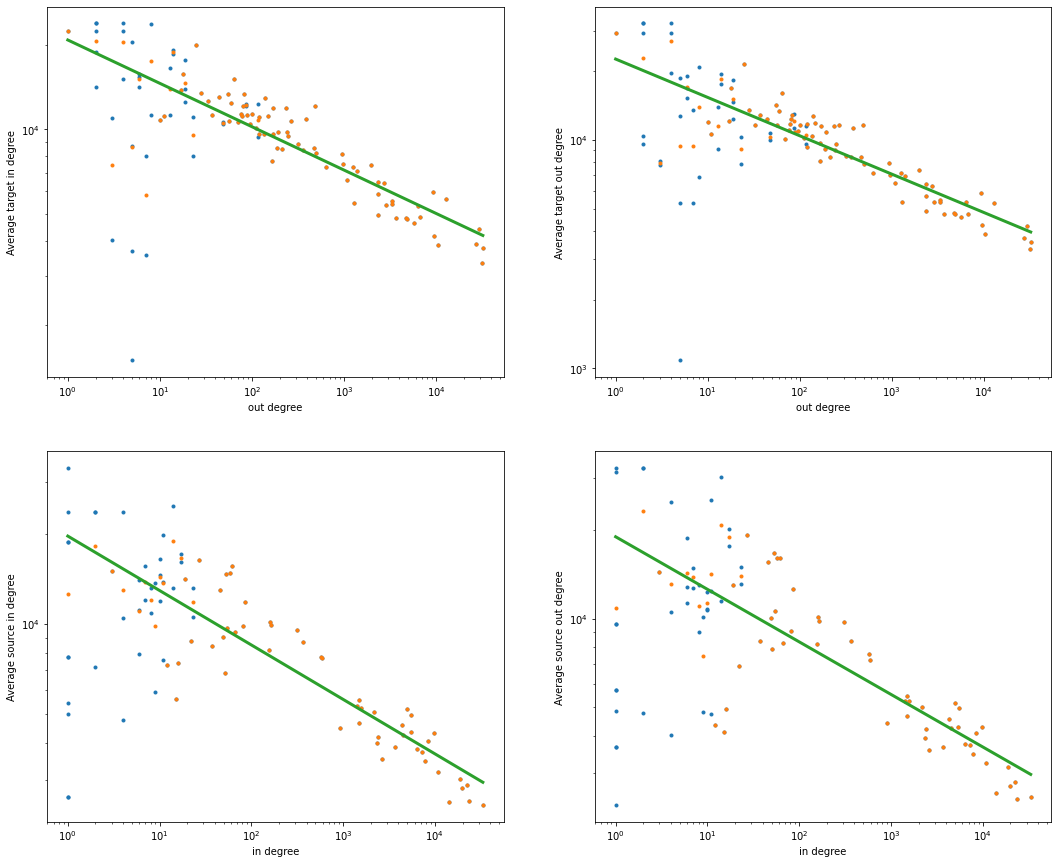

(-0.1544304249297988, -0.16778856685274204, -0.18258937454941349, -0.17804032141718953)


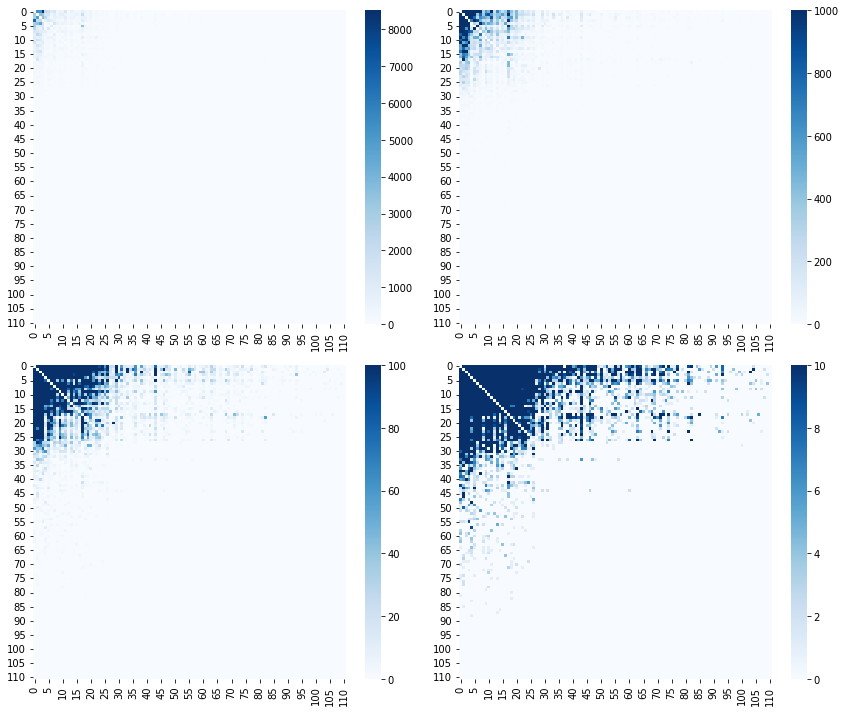

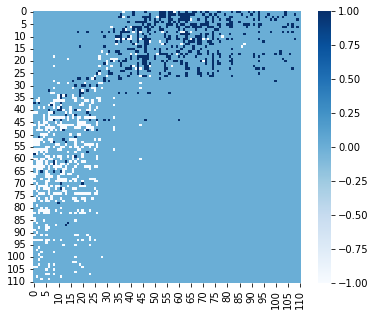

In [6]:
country16_df = pd.read_csv('data\Erasmus16.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country16_df)

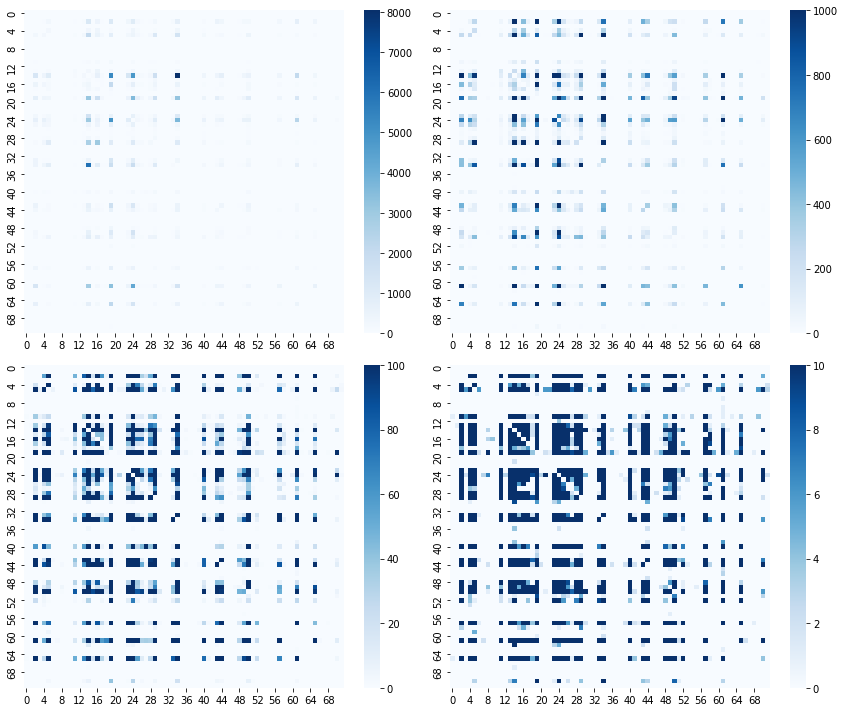

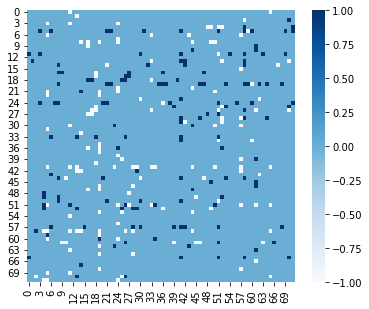

Number of components = 1


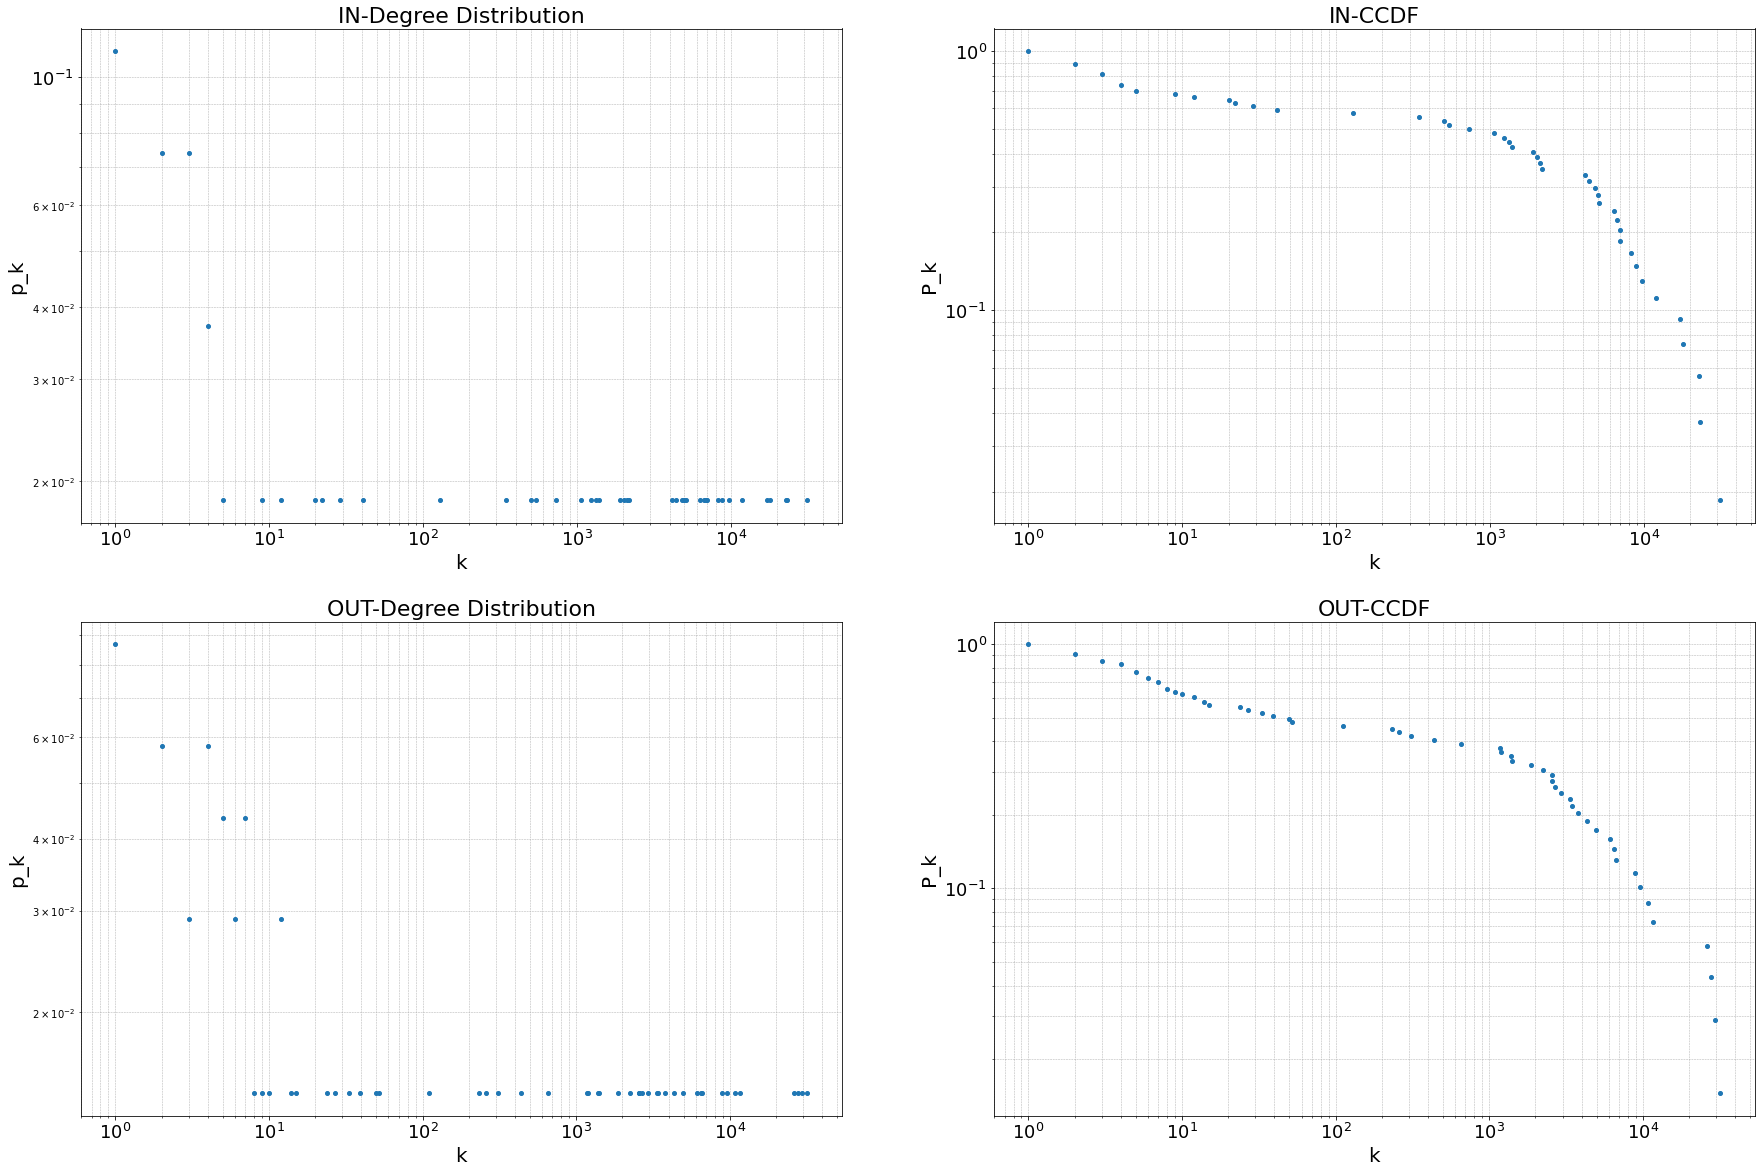

Top 10 for in degree


Nodes  in degree
14        Spain      31328
19      Germany      23334
24       France      22774
61           UK      17896
34        Italy      17313
29       Poland      11915
5      Portugal       9770
2   Netherlands       8832
65       Sweden       8277
43      Finland       6992

Top 10 for out degree


Nodes  out degree
19      Germany       31842
14        Spain       29491
24       France       27790
34        Italy       26119
16       Turkey       11601
29       Poland       10874
61           UK        9630
2   Netherlands        8838
23      Belgium        6641
50      Czechia        6492

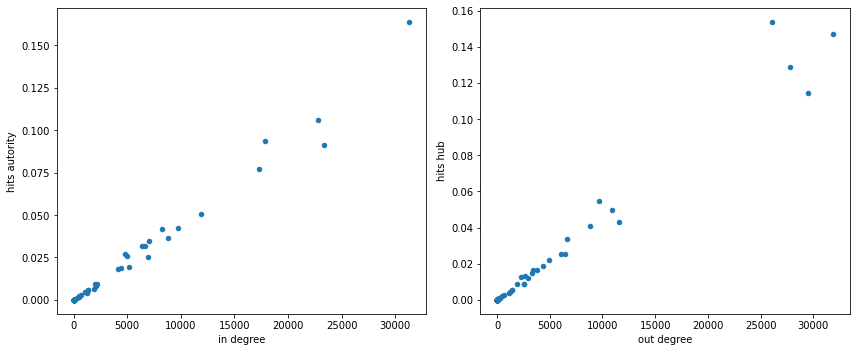

Top 10 for hits hub


Nodes  hits hub
34        Italy  0.153959
19      Germany  0.147386
24       France  0.128948
14        Spain  0.114324
61           UK  0.054692
29       Poland  0.049684
16       Turkey  0.042843
2   Netherlands  0.040712
23      Belgium  0.033620
5      Portugal  0.025642

Top 10 for hits autority


Nodes  hits autority
14        Spain       0.164030
24       France       0.106196
61           UK       0.093642
19      Germany       0.091452
34        Italy       0.076907
29       Poland       0.050483
5      Portugal       0.042417
65       Sweden       0.041725
2   Netherlands       0.036388
43      Finland       0.034568

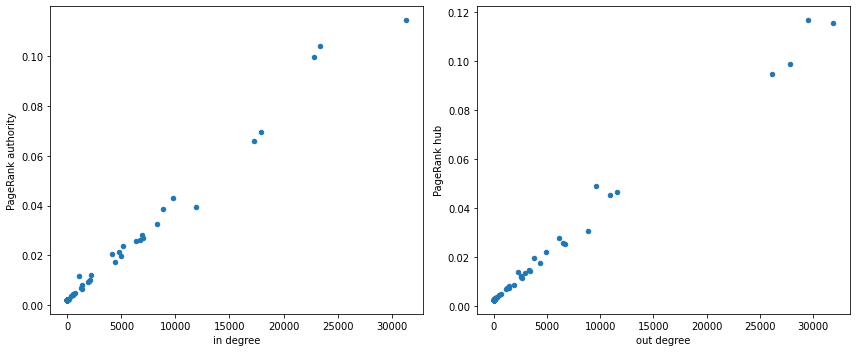

Top 10 for PageRank hub


Nodes  PageRank hub
14        Spain      0.116762
19      Germany      0.115689
24       France      0.098750
34        Italy      0.094661
61           UK      0.048974
16       Turkey      0.046628
29       Poland      0.045302
2   Netherlands      0.030773
5      Portugal      0.028010
50      Czechia      0.026003

Top 10 for PageRank authority


Nodes  PageRank authority
14        Spain            0.114362
19      Germany            0.104124
24       France            0.099493
61           UK            0.069481
34        Italy            0.066042
5      Portugal            0.042854
29       Poland            0.039454
2   Netherlands            0.038527
65       Sweden            0.032644
50      Czechia            0.028223

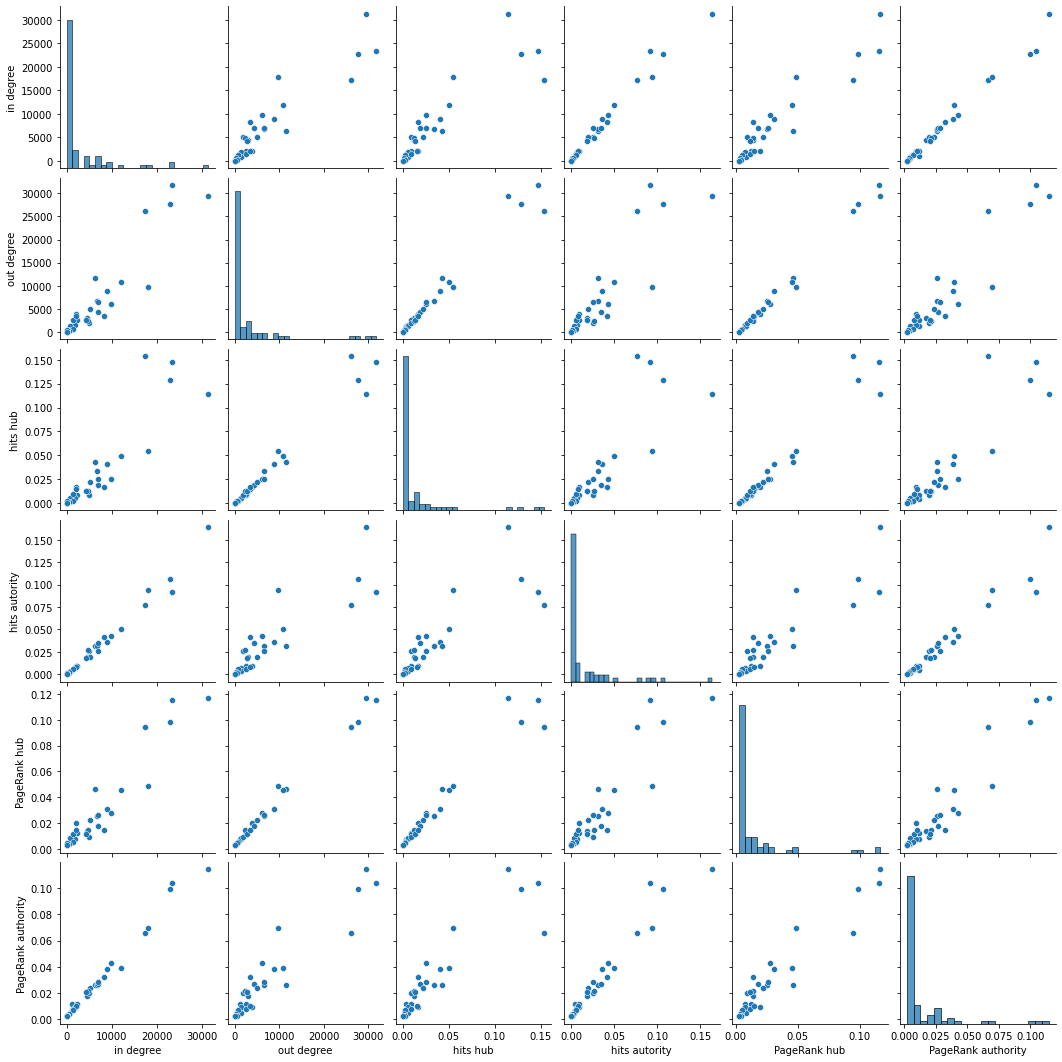

Nodes  in degree  in degree position  hits autority  \
14               Spain      31328                   1       0.164030   
19             Germany      23334                   2       0.091452   
24              France      22774                   3       0.106196   
61                  UK      17896                   4       0.093642   
34               Italy      17313                   5       0.076907   
5             Portugal       9770                   7       0.042417   
29              Poland      11915                   6       0.050483   
2          Netherlands       8832                   8       0.036388   
65              Sweden       8277                   9       0.041725   
50             Czechia       6950                  11       0.025480   
43             Finland       6992                  10       0.034568   
23             Belgium       6689                  12       0.031768   
16              Turkey       6356                  13       0.031474   
44             Austria       5143                  14       0.019585   
49             Ireland       4808                  16       0.026830   
57             Denmark       4153                  18       0.018201   
33              Norway       5003                  15       0.025615   
25             Hungary       4419                  17       0.019052   
13           Lithuania       2185                  19       0.009079   
11              Latvia       1065                  26       0.004839   
40                  EL       2115                  20       0.008328   
4              Romania       2014                  21       0.009355   
17            Slovenia       1910                  22       0.006646   
28            Slovakia       1387                  23       0.005585   
15             Croatia       1242                  25       0.004221   
48             Estonia       1326                  24       0.006006   
26            Bulgaria        735                  27       0.003097   
27              Cyprus        539                  28       0.001746   
52             Iceland        505                  29       0.002442   
18               Malta        347                  30       0.001382   
70          Luxembourg        129                  31       0.000776   
51       Liechtenstein         41                  32       0.000120   
30  Russian Federation         29                  33       0.000149   
62       United States         22                  34       0.000115   
58     North Macedonia         20                  35       0.000052   
39  Korea, Republic of         12                  36       0.000044   
36              Canada          9                  37       0.000041   
59              Brazil          5                  38       0.000007   
45           Hong Kong          3                  43       0.000007   
46            Thailand          3                  44       0.000009   

    hits autority position  PageRank authority  PageRank authority position  
14                       1            0.114362                            1  
19                       4            0.104124                            2  
24                       2            0.099493                            3  
61                       3            0.069481                            4  
34                       5            0.066042                            5  
5                        7            0.042854                            6  
29                       6            0.039454                            7  
2                        9            0.038527                            8  
65                       8            0.032644                            9  
50                      15            0.028223                           10  
43                      10            0.026799                           11  
23                      11            0.026297                           12  
16                      12            0.025807    

Nodes  out degree  out degree position  hits hub  \
14               Spain       29491                    2  0.114324   
19             Germany       31842                    1  0.147386   
24              France       27790                    3  0.128948   
34               Italy       26119                    4  0.153959   
61                  UK        9630                    7  0.054692   
16              Turkey       11601                    5  0.042843   
29              Poland       10874                    6  0.049684   
2          Netherlands        8838                    8  0.040712   
5             Portugal        6081                   11  0.025642   
50             Czechia        6492                   10  0.025322   
23             Belgium        6641                    9  0.033620   
44             Austria        4940                   12  0.022294   
4              Romania        3770                   14  0.016433   
43             Finland        4329                   13  0.018747   
40                  EL        3337                   16  0.015089   
65              Sweden        3436                   15  0.016781   
49             Ireland        2255                   21  0.012472   
25             Hungary        2944                   17  0.012341   
13           Lithuania        2550                   20  0.008745   
28            Slovakia        2568                   19  0.009045   
57             Denmark        2683                   18  0.013080   
33              Norway        1869                   22  0.008825   
26            Bulgaria        1378                   24  0.005649   
17            Slovenia        1407                   23  0.005383   
15             Croatia        1191                   25  0.004348   
11              Latvia        1173                   26  0.003807   
48             Estonia         653                   27  0.002497   
70          Luxembourg         439                   28  0.002321   
27              Cyprus         310                   29  0.001054   
52             Iceland         260                   30  0.000968   
18               Malta         232                   31  0.000957   
58     North Macedonia         111                   32  0.000276   
41             Ukraine          52                   33  0.000180   
30  Russian Federation          50                   34  0.000287   
21             Morocco          39                   35  0.000230   
8                China          33                   36  0.000170   
53              Serbia          24                   38  0.000109   
51       Liechtenstein          27                   37  0.000098   
3              Algeria          14                   40  0.000031   
36              Canada          12                   42  0.000070   

    hits hub position  PageRank hub  PageRank hub position  
14                  4      0.116762                      1  
19                  2      0.115689                      2  
24                  3      0.098750                      3  
34                  1      0.094661                      4  
61                  5      0.048974                      5  
16                  7      0.046628                      6  
29                  6      0.045302                      7  
2                   8      0.030773                      8  
5                  10      0.028010                      9  
50                 11      0.026003                     10  
23                  9      0.025457                     11  
44                 12      0.022232                     12  
4                  15      0.019659                     13  
43                 13      0.017803                     14  
40                 16      0.014721                     15  
65                 14      0.014326                     16  
49                 18      0.014202                     17  
25                 19      0.013761                     18  
13                 22      0

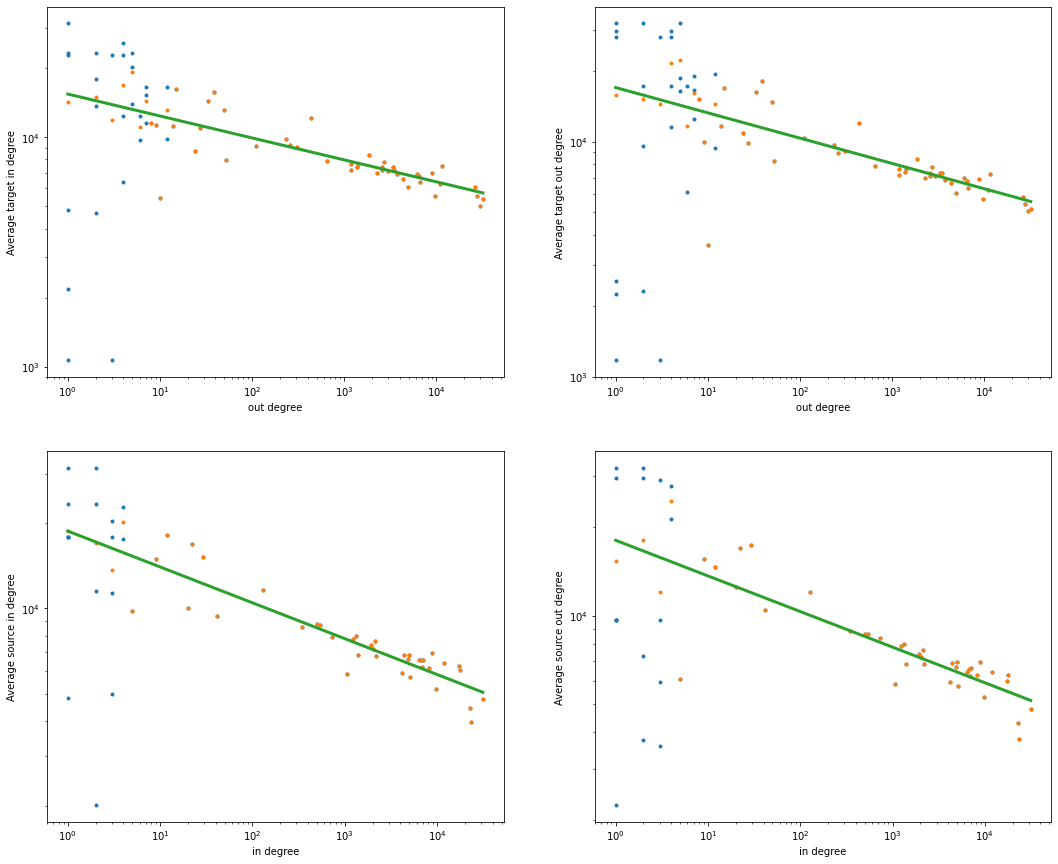

(-0.09567862679402746, -0.10766937303520784, -0.1268215594385636, -0.12154368544529677)


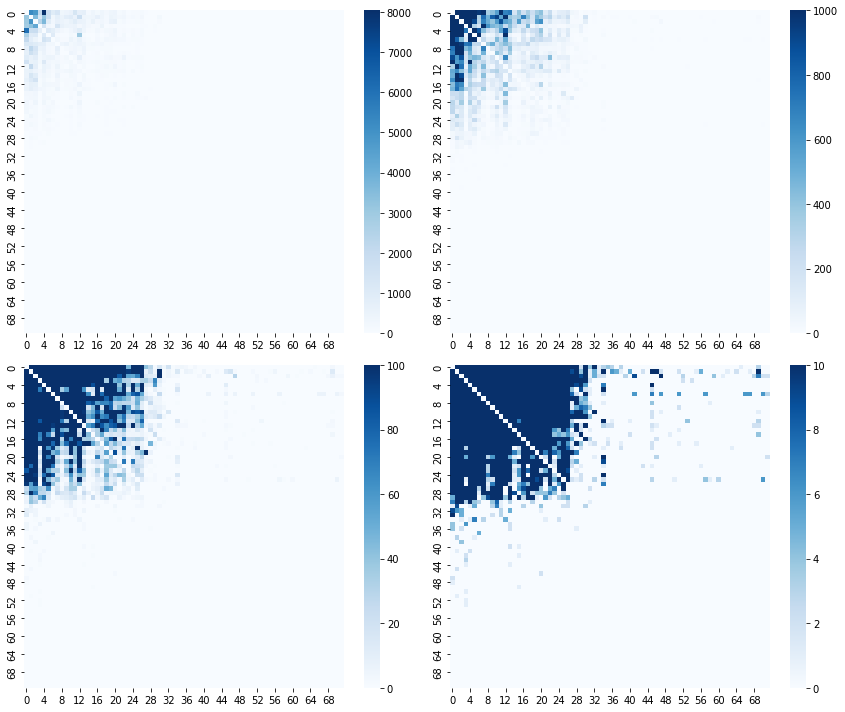

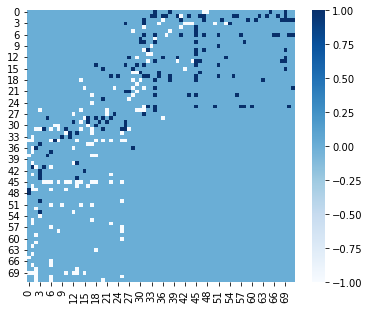

In [7]:
country15_df = pd.read_csv('data\Erasmus15.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country15_df)

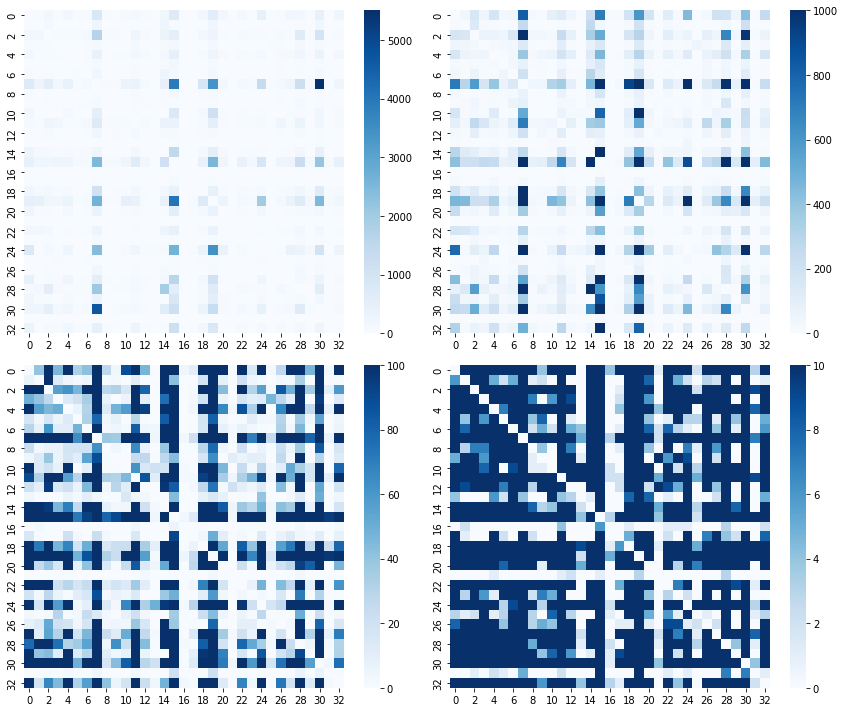

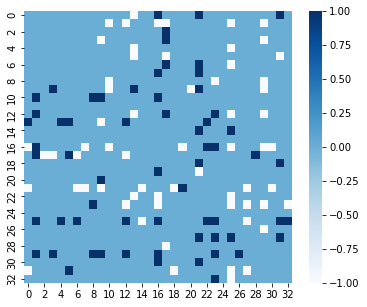

Number of components = 1


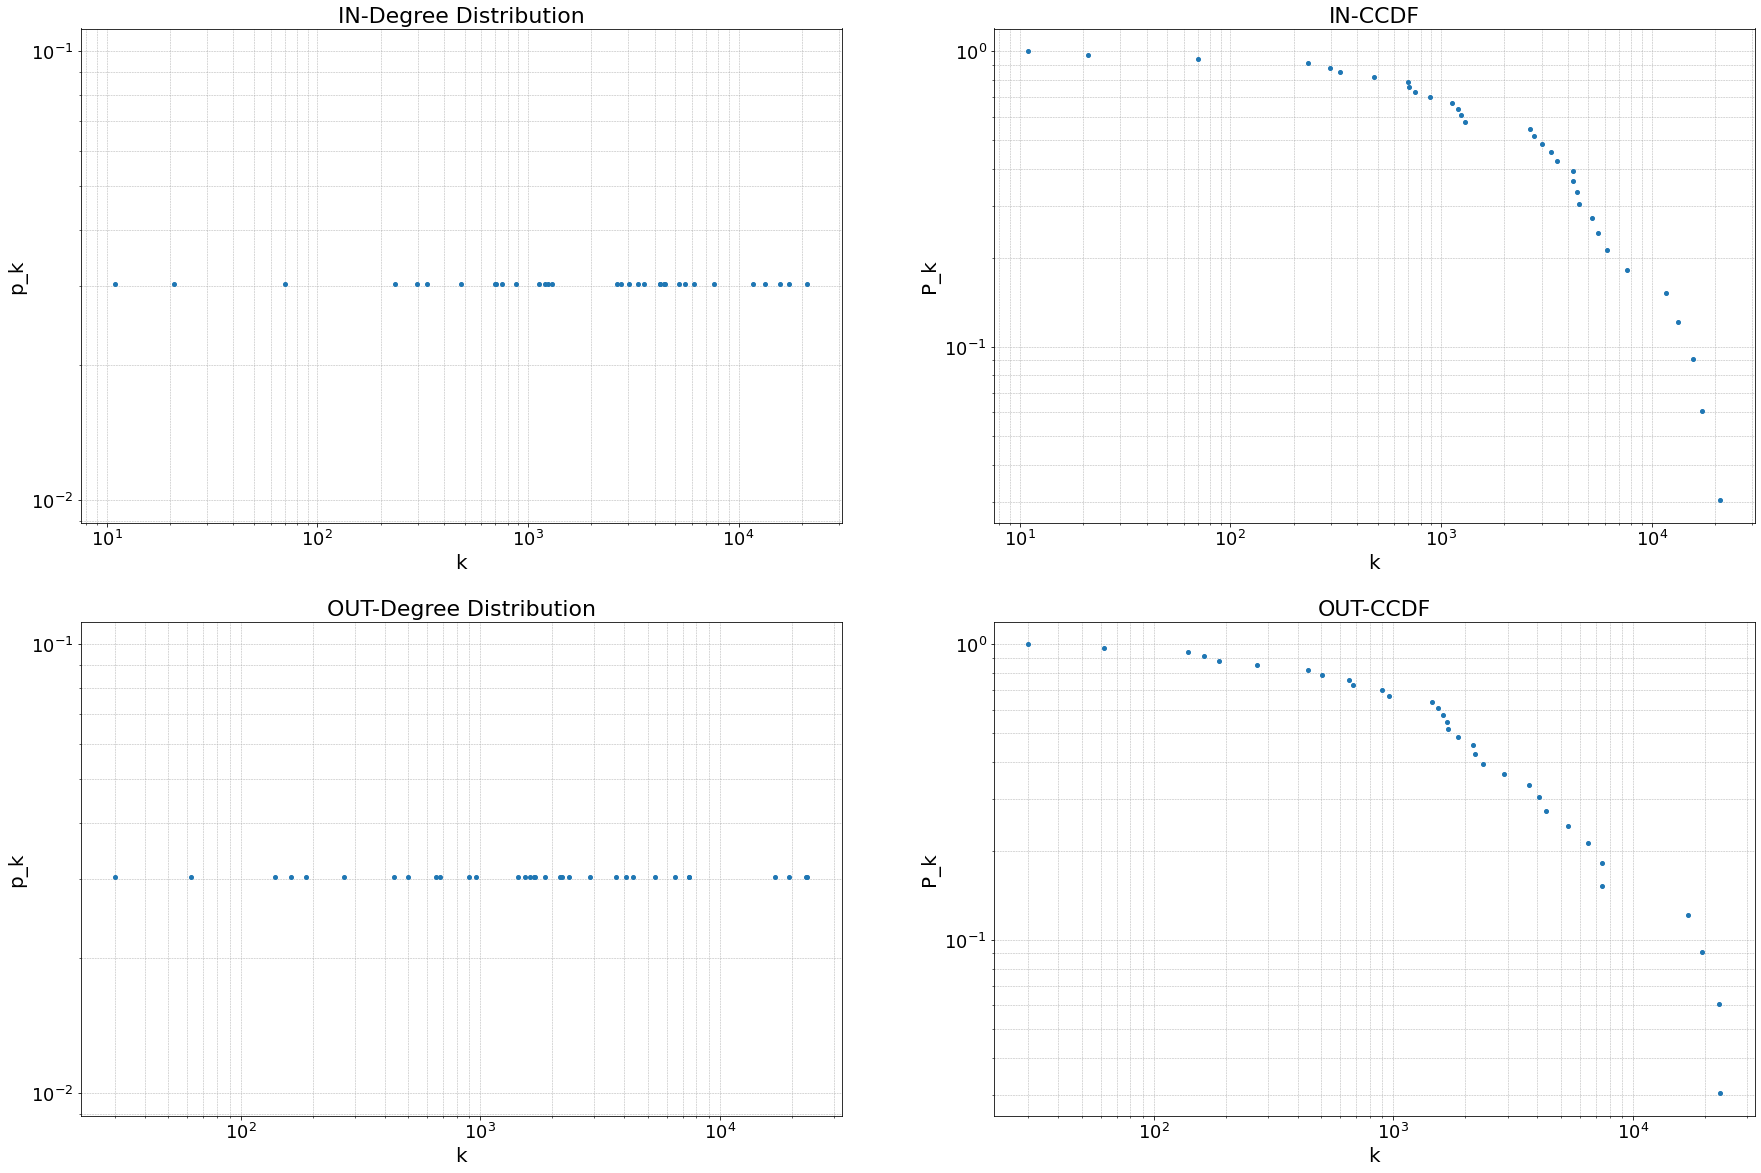

Top 10 for in degree


Nodes  in degree
7         Spain      21119
19       France      17250
15      Germany      15714
24           UK      13281
30        Italy      11699
28       Poland       7628
2      Portugal       6146
27       Sweden       5562
0   Netherlands       5232
32      Finland       4494

Top 10 for out degree


Nodes  out degree
7         Spain       23155
15      Germany       22824
19       France       19399
30        Italy       17047
28       Poland        7462
14       Turkey        7441
24           UK        6492
0   Netherlands        5390
18      Belgium        4330
11      Czechia        4066

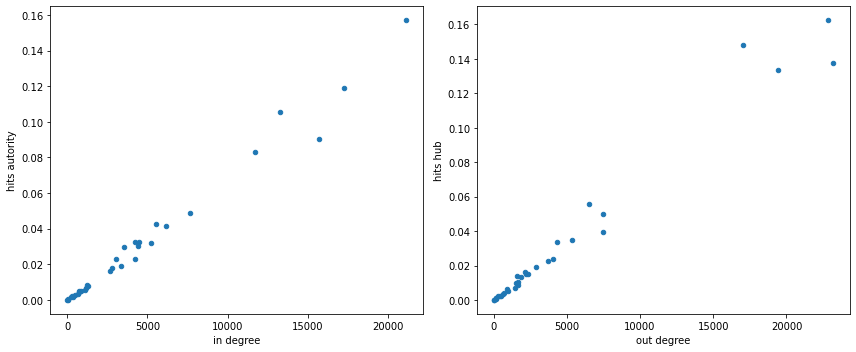

Top 10 for hits hub


Nodes  hits hub
15      Germany  0.162275
30        Italy  0.147887
7         Spain  0.137271
19       France  0.133438
24           UK  0.055983
28       Poland  0.050064
14       Turkey  0.039574
0   Netherlands  0.035035
18      Belgium  0.033543
11      Czechia  0.023626

Top 10 for hits autority


Nodes  hits autority
7      Spain       0.156956
19    France       0.118921
24        UK       0.105617
15   Germany       0.090148
30     Italy       0.082788
28    Poland       0.048618
27    Sweden       0.042787
2   Portugal       0.041566
32   Finland       0.032696
14    Turkey       0.032405

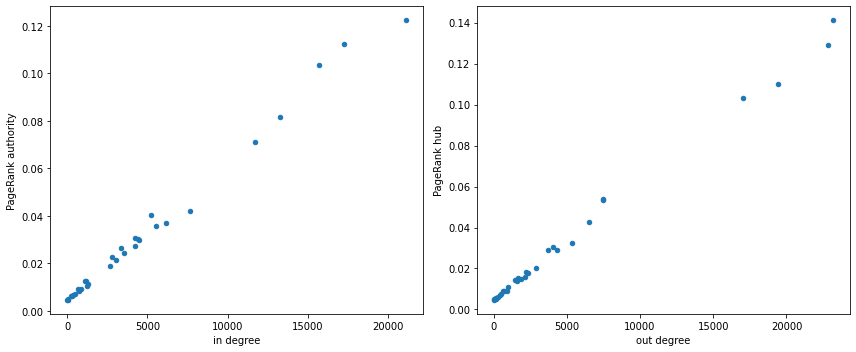

Top 10 for PageRank hub


Nodes  PageRank hub
7         Spain      0.141112
15      Germany      0.129106
19       France      0.110293
30        Italy      0.103348
28       Poland      0.054073
14       Turkey      0.053611
24           UK      0.042490
0   Netherlands      0.032353
11      Czechia      0.030299
2      Portugal      0.029030

Top 10 for PageRank authority


Nodes  PageRank authority
7         Spain            0.122351
19       France            0.112269
15      Germany            0.103498
24           UK            0.081532
30        Italy            0.070998
28       Poland            0.041874
0   Netherlands            0.040290
2      Portugal            0.036863
27       Sweden            0.035680
11      Czechia            0.030777

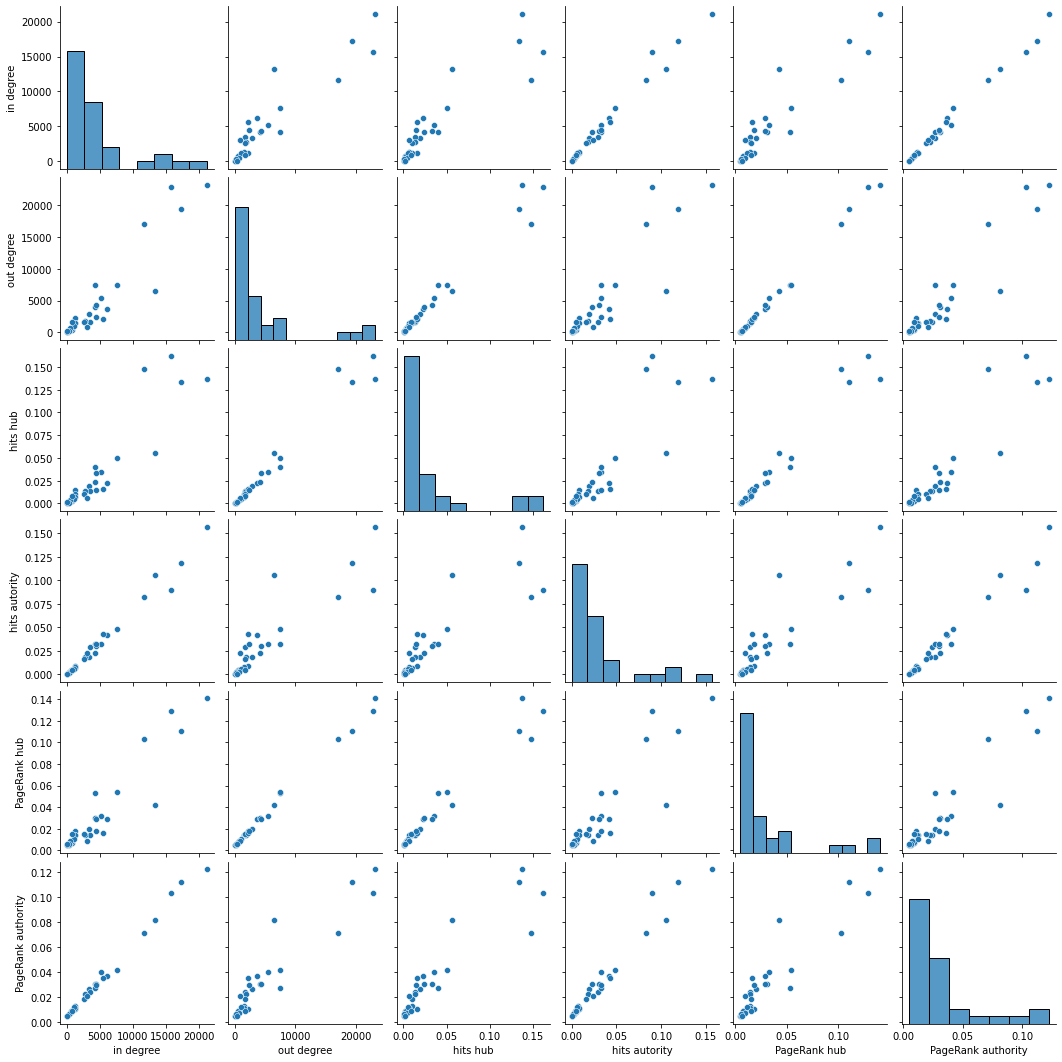

Nodes  in degree  in degree position  hits autority  \
7             Spain      21119                   1       0.156956   
19           France      17250                   2       0.118921   
15          Germany      15714                   3       0.090148   
24               UK      13281                   4       0.105617   
30            Italy      11699                   5       0.082788   
28           Poland       7628                   6       0.048618   
0       Netherlands       5232                   9       0.032177   
2          Portugal       6146                   7       0.041566   
27           Sweden       5562                   8       0.042787   
11          Czechia       4234                  13       0.023135   
18          Belgium       4413                  11       0.030519   
32          Finland       4494                  10       0.032696   
14           Turkey       4251                  12       0.032405   
4           Austria       3342                  15       0.019049   
10          Ireland       3545                  14       0.029458   
20          Denmark       2764                  17       0.018001   
29           Norway       3021                  16       0.023204   
22          Hungary       2648                  18       0.016353   
3                EL       1201                  21       0.006676   
12         Slovenia       1130                  22       0.005621   
6         Lithuania       1306                  19       0.007822   
1           Romania       1247                  20       0.008469   
26         Slovakia        882                  23       0.005118   
9           Croatia        697                  26       0.003269   
8           Estonia        756                  24       0.004975   
5            Latvia        704                  25       0.004647   
23         Bulgaria        483                  27       0.002911   
25           Cyprus        332                  28       0.001673   
17          Iceland        297                  29       0.002126   
13            Malta        234                  30       0.001527   
31       Luxembourg         70                  31       0.000613   
16    Liechtenstein         21                  32       0.000100   
21  North Macedonia         11                  33       0.000055   

    hits autority position  PageRank authority  PageRank authority position  
7                        1            0.122351                            1  
19                       2            0.112269                            2  
15                       4            0.103498                            3  
24                       3            0.081532                            4  
30                       5            0.070998                            5  
28                       6            0.041874                            6  
0                       11            0.040290                            7  
2                        8            0.036863                            8  
27                       7            0.035680                            9  
11                      15            0.030777                           10  
18                      12            0.030385                           11  
32                       9            0.029802                           12  
14                      10            0.027118                           13  
4                       16            0.026471                           14  
10                      13            0.024297                           15  
20                      17            0.022712                           16  
29                      14            0.021254                           17  
22                      18            0.018899                           18  
3                       21            0.012545                           19  
12                      22            0.012368                           20  
6                       20   

Nodes  out degree  out degree position  hits hub  \
7             Spain       23155                    1  0.137271   
15          Germany       22824                    2  0.162275   
19           France       19399                    3  0.133438   
30            Italy       17047                    4  0.147887   
28           Poland        7462                    5  0.050064   
14           Turkey        7441                    6  0.039574   
24               UK        6492                    7  0.055983   
0       Netherlands        5390                    8  0.035035   
11          Czechia        4066                   10  0.023626   
2          Portugal        3694                   11  0.022424   
18          Belgium        4330                    9  0.033543   
4           Austria        2887                   12  0.019040   
1           Romania        2196                   14  0.015245   
32          Finland        2360                   13  0.015171   
27           Sweden        2159                   15  0.016356   
26         Slovakia        1681                   18  0.008573   
22          Hungary        1692                   17  0.010578   
20          Denmark        1860                   16  0.013242   
6         Lithuania        1445                   21  0.006855   
3                EL        1539                   20  0.009965   
10          Ireland        1611                   19  0.013796   
12         Slovenia         958                   22  0.005292   
29           Norway         899                   23  0.006516   
23         Bulgaria         682                   24  0.004288   
5            Latvia         652                   25  0.003334   
9           Croatia         502                   26  0.002617   
8           Estonia         439                   27  0.002435   
31       Luxembourg         271                   28  0.002151   
25           Cyprus         162                   30  0.000952   
17          Iceland         188                   29  0.001245   
13            Malta         139                   31  0.000883   
21  North Macedonia          62                   32  0.000155   
16    Liechtenstein          30                   33  0.000191   

    hits hub position  PageRank hub  PageRank hub position  
7                   3      0.141112                      1  
15                  1      0.129106                      2  
19                  4      0.110293                      3  
30                  2      0.103348                      4  
28                  6      0.054073                      5  
14                  7      0.053611                      6  
24                  5      0.042490                      7  
0                   8      0.032353                      8  
11                 10      0.030299                      9  
2                  11      0.029030                     10  
18                  9      0.028949                     11  
4                  12      0.020286                     12  
1                  14      0.018381                     13  
32                 15      0.018006                     14  
27                 13      0.016049                     15  
26                 20      0.015143                     16  
22                 18      0.015005                     17  
20                 17      0.014631                     18  
6                  21      0.014240                     19  
3                  19      0.014236                     20  
10                 16      0.013981                     21  
12                 23      0.011038                     22  
29                 22      0.009230                     23  
23                 24      0.009153                     24  
5                  25      0.008935                     25  
9                  26      0.007738                     26  
8                  27      0.007054                     27  
31                 28      0.006142                     28  


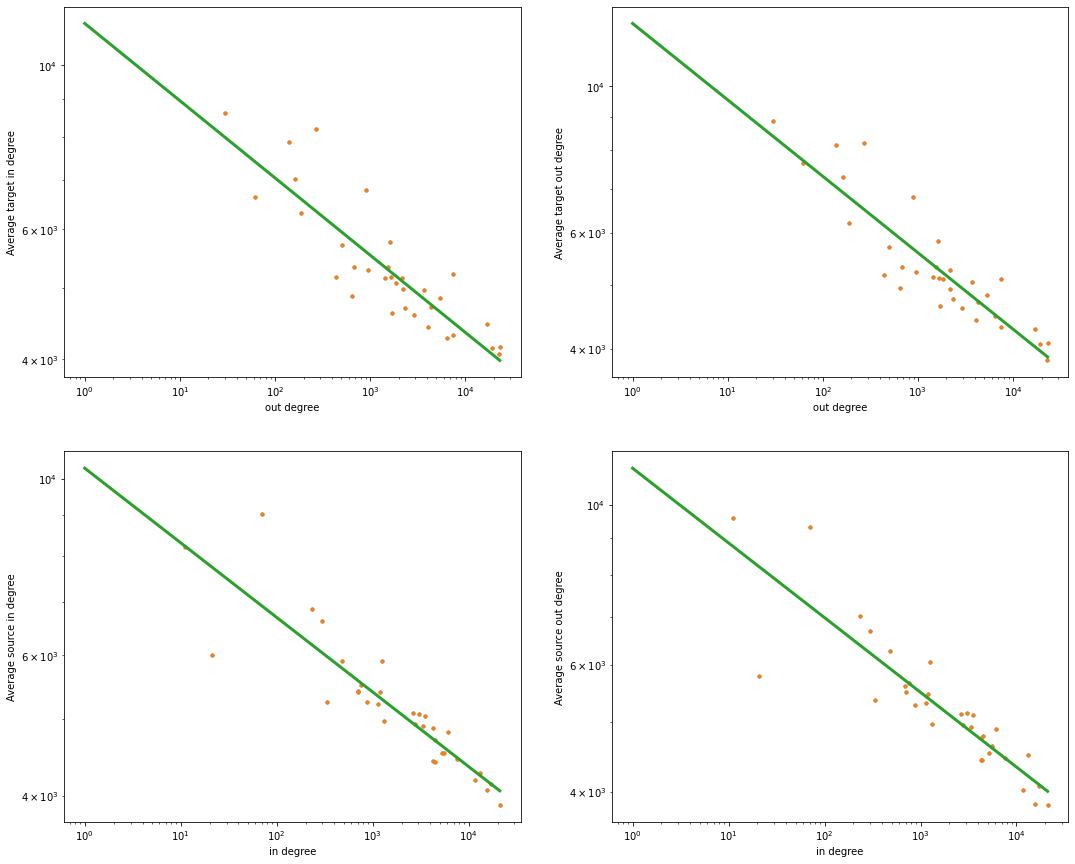

(-0.10455240865841625, -0.11594182711442622, -0.09360541404419462, -0.1037260967588432)


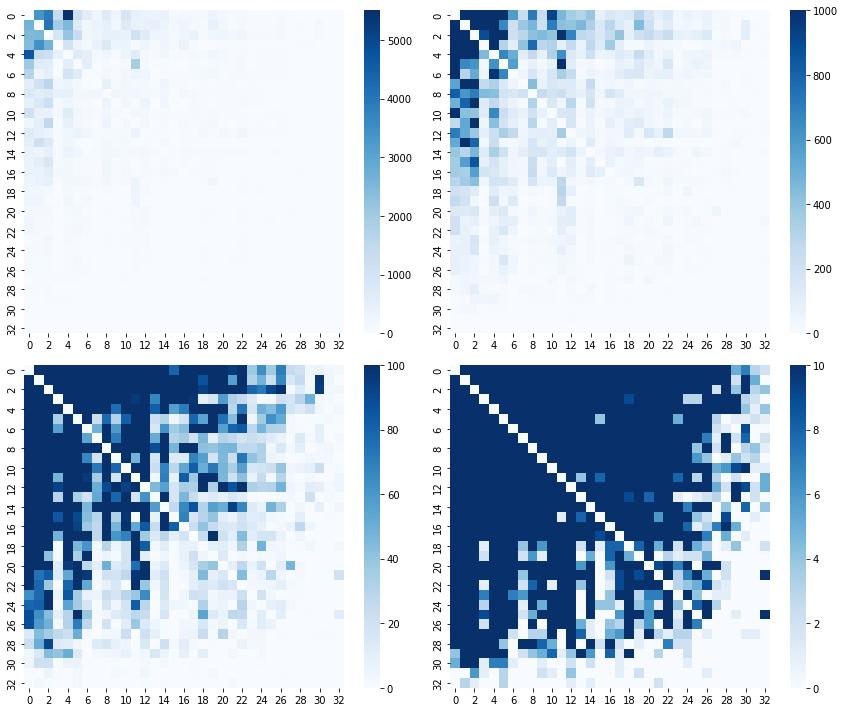

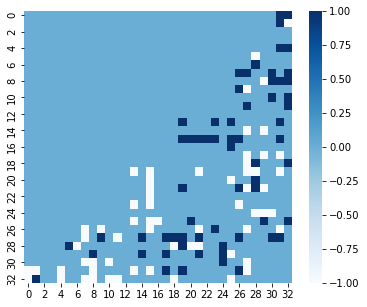

In [8]:
country14_df = pd.read_csv('data\Erasmus14.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country14_df)

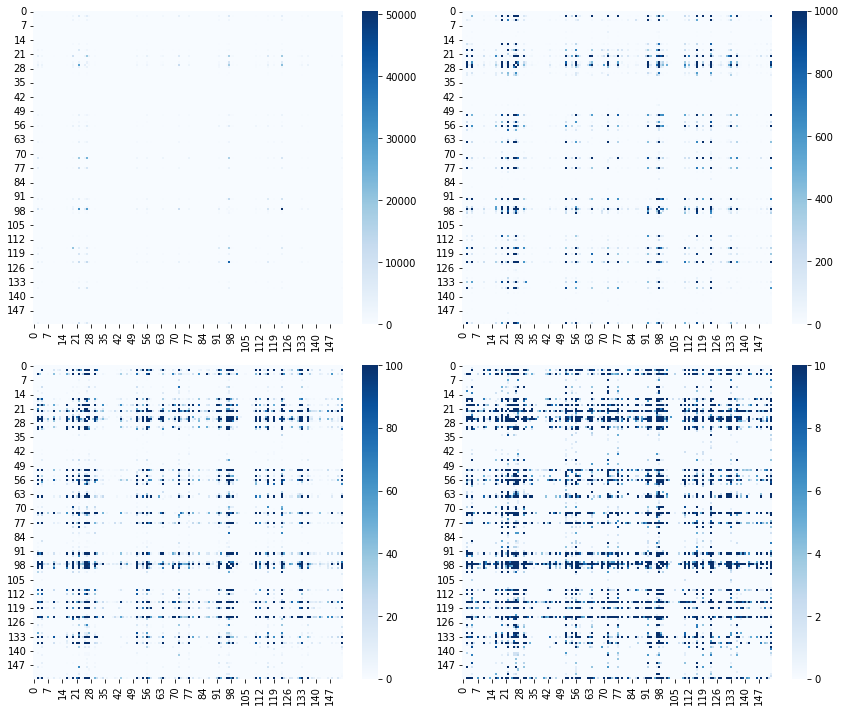

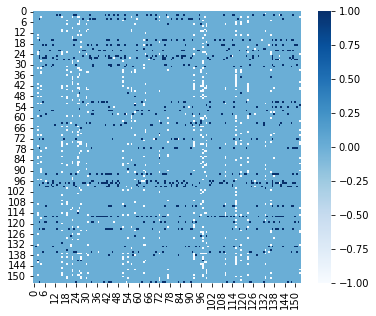

Number of components = 2


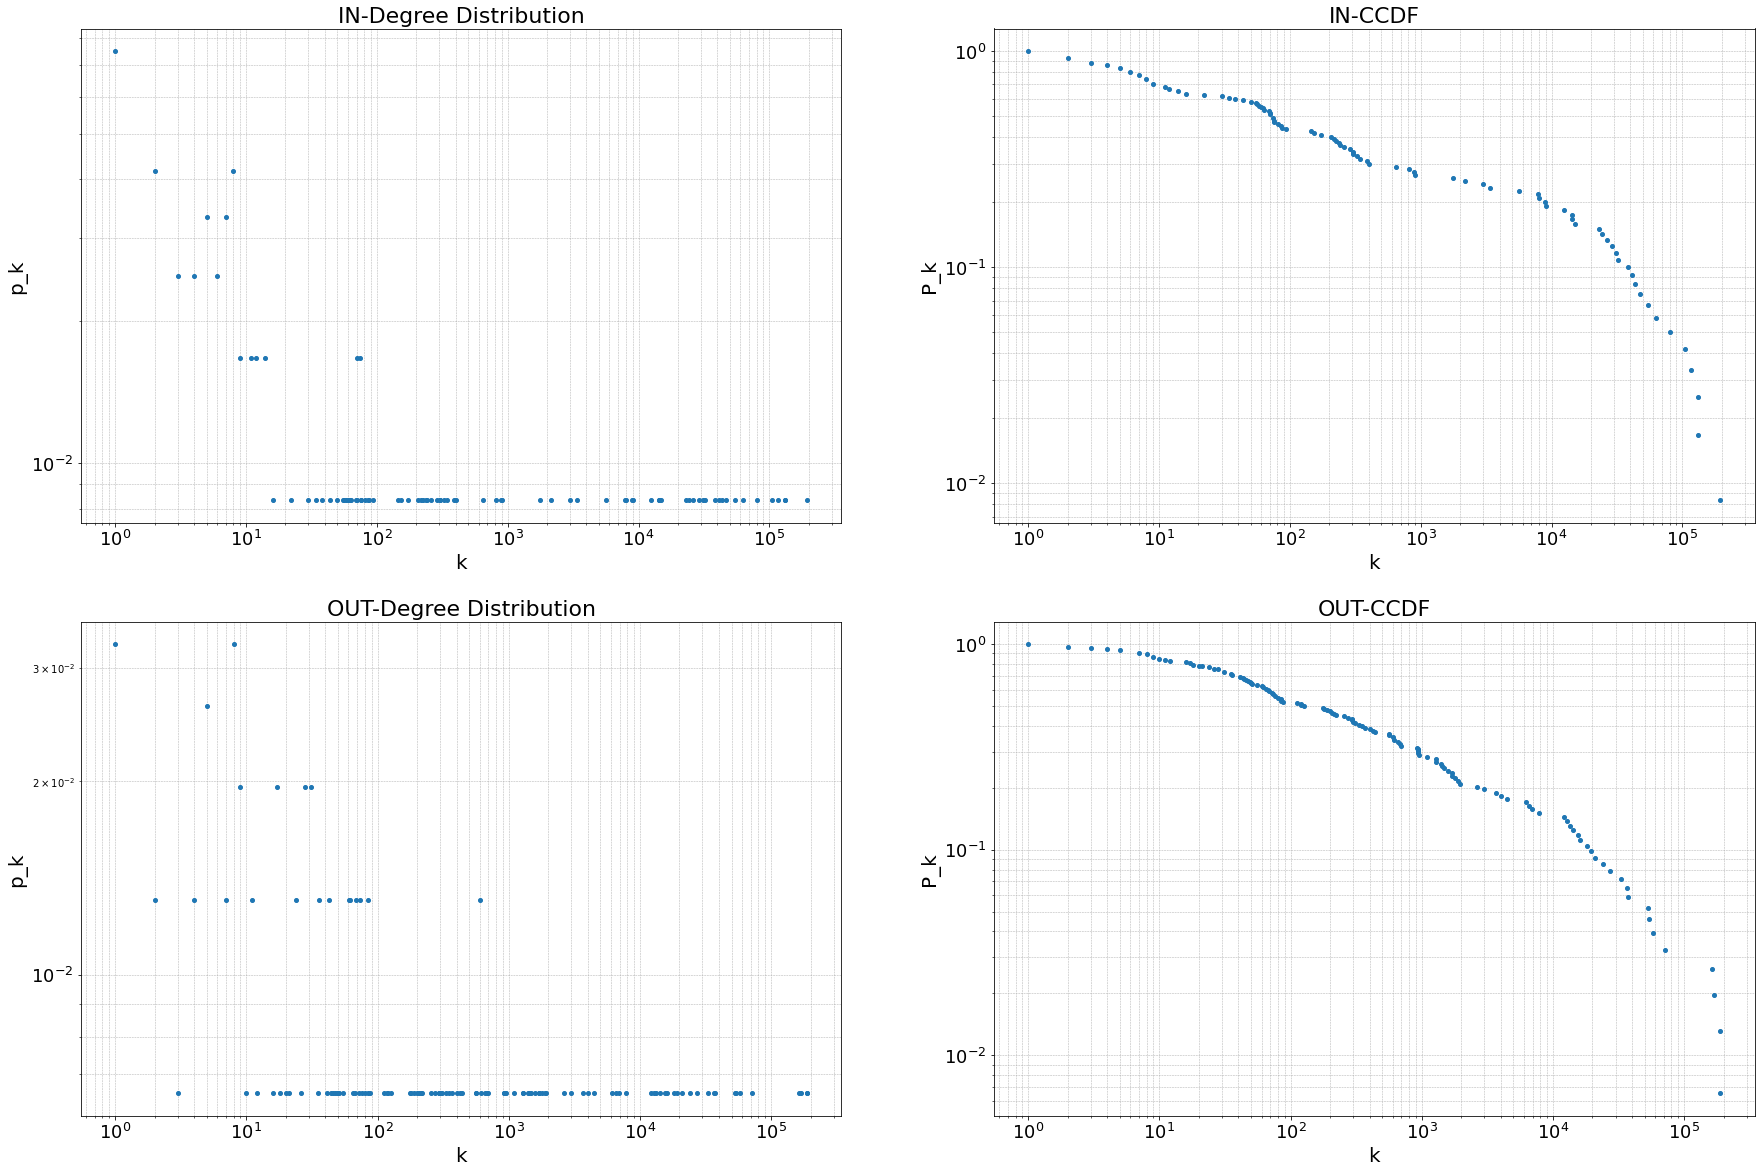

Top 10 for in degree


Nodes  in degree
97         Spain     193628
22       Germany     131451
26        France     130821
123        Italy     116180
72            UK     103962
116       Poland      79774
92      Portugal      63268
2    Netherlands      54828
77        Sweden      47028
56       Czechia      43532

Top 10 for out degree


Nodes  out degree
22       Germany      187627
97         Spain      186670
26        France      168162
123        Italy      162235
19        Turkey       71621
116       Poland       58299
72            UK       53862
2    Netherlands       53340
25       Belgium       37427
92      Portugal       36678

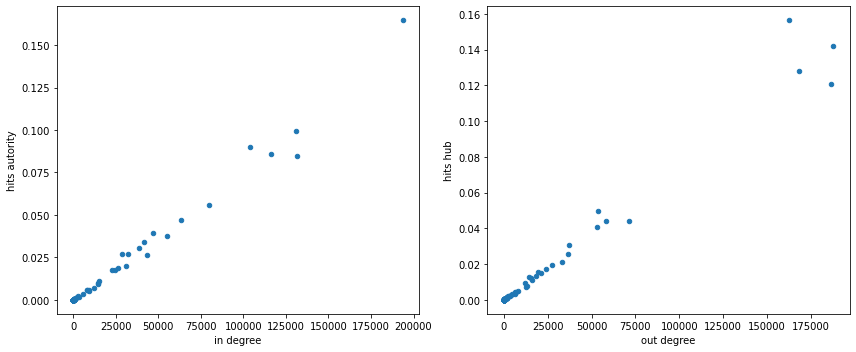

Top 10 for hits hub


Nodes  hits hub
123        Italy  0.156293
22       Germany  0.141831
26        France  0.128110
97         Spain  0.120733
72            UK  0.049901
116       Poland  0.044319
19        Turkey  0.043977
2    Netherlands  0.040685
25       Belgium  0.030840
92      Portugal  0.025639

Top 10 for hits autority


Nodes  hits autority
97         Spain       0.164556
26        France       0.099586
72            UK       0.089991
123        Italy       0.085836
22       Germany       0.084588
116       Poland       0.056051
92      Portugal       0.046731
77        Sweden       0.039643
2    Netherlands       0.037504
153      Finland       0.033788

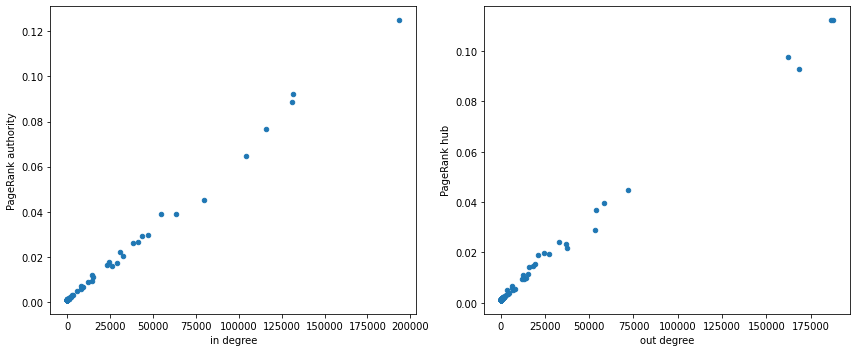

Top 10 for PageRank hub


Nodes  PageRank hub
22       Germany      0.112138
97         Spain      0.112125
123        Italy      0.097475
26        France      0.092776
19        Turkey      0.044988
116       Poland      0.039472
72            UK      0.036884
2    Netherlands      0.028761
56       Czechia      0.024009
92      Portugal      0.023171

Top 10 for PageRank authority


Nodes  PageRank authority
97         Spain            0.124839
22       Germany            0.092253
26        France            0.088529
123        Italy            0.076540
72            UK            0.064553
116       Poland            0.045153
92      Portugal            0.039174
2    Netherlands            0.038861
77        Sweden            0.029709
56       Czechia            0.029178

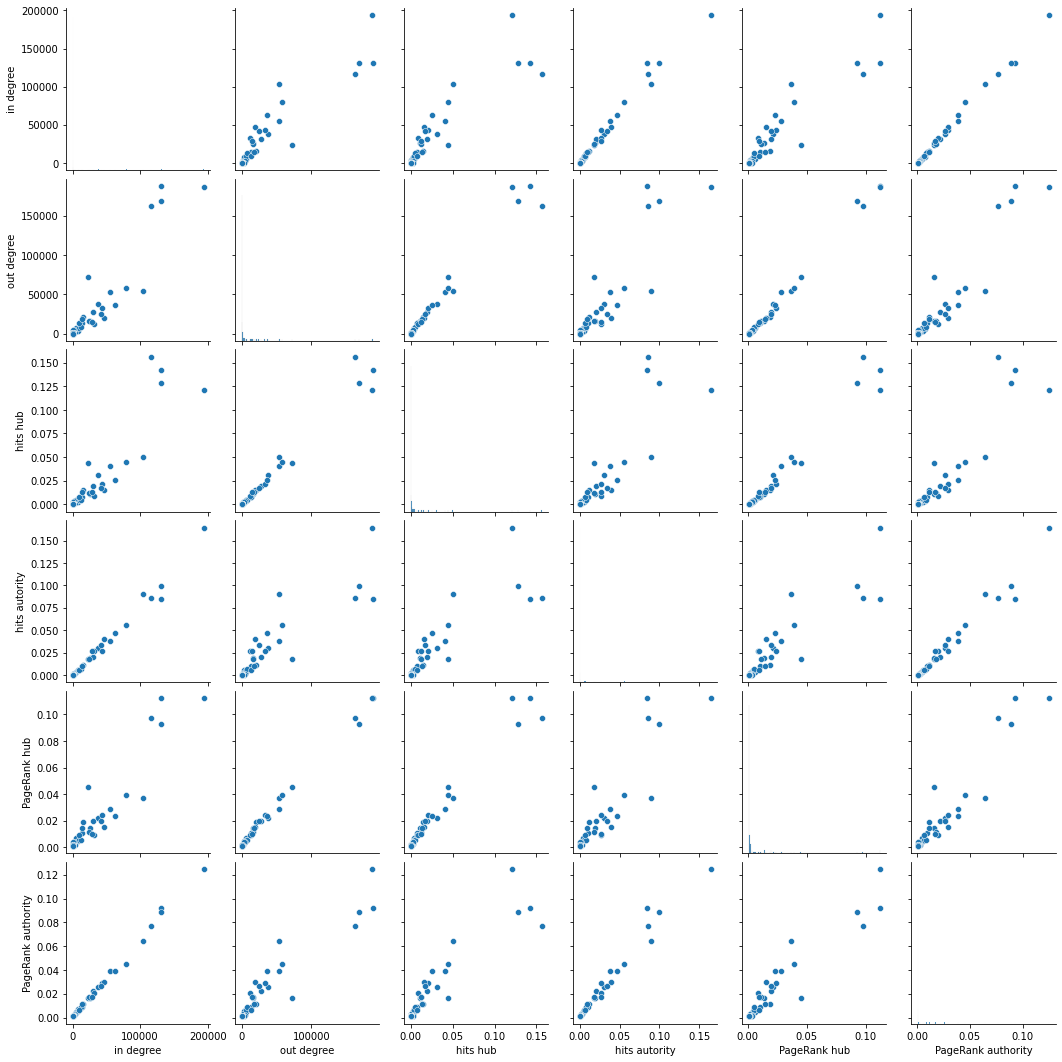

Nodes  in degree  in degree position  hits autority  \
97                    Spain     193628                   1       0.164556   
22                  Germany     131451                   2       0.084588   
26                   France     130821                   3       0.099586   
123                   Italy     116180                   4       0.085836   
72                       UK     103962                   5       0.089991   
116                  Poland      79774                   6       0.056051   
92                 Portugal      63268                   7       0.046731   
2               Netherlands      54828                   8       0.037504   
77                   Sweden      47028                   9       0.039643   
56                  Czechia      43532                  10       0.026612   
153                 Finland      41491                  11       0.033788   
25                  Belgium      38404                  12       0.030425   
51                  Austria      30949                  14       0.020008   
119                  Norway      32344                  13       0.027140   
64                  Denmark      24228                  17       0.017316   
136                 Ireland      28897                  15       0.026713   
19                   Turkey      23039                  18       0.017419   
27                  Hungary      26280                  16       0.018527   
133                      EL      14333                  20       0.009585   
4                   Romania      14966                  19       0.011204   
96                Lithuania      14273                  21       0.009962   
99                 Slovenia      12383                  22       0.007141   
16                   Latvia       8064                  25       0.006076   
98                  Croatia       9059                  23       0.005239   
110                Slovakia       8950                  24       0.005978   
54                  Estonia       7844                  26       0.005851   
30                 Bulgaria       5609                  27       0.003485   
31                   Cyprus       3364                  28       0.001827   
58                  Iceland       2995                  29       0.002287   
21                    Malta       2161                  30       0.001473   
112      Russian Federation       1758                  31       0.001265   
131                  Israel        892                  33       0.000605   
57                   Serbia        908                  32       0.000602   
63               Luxembourg        812                  34       0.000725   
73            United States        643                  35       0.000460   
127                  Canada        401                  36       0.000289   
10                    China        302                  41       0.000125   
69          North Macedonia        390                  37       0.000238   
124  Bosnia and Herzegovina        345                  38       0.000210   
17                    Japan        326                  39       0.000264   

     hits autority position  PageRank authority  PageRank authority position  
97                        1            0.124839                            1  
22                        5            0.092253                            2  
26                        2            0.088529                            3  
123                       4            0.076540                            4  
72                        3            0.064553                            5  
116                       6            0.045153                            6  
92                        7            0.039174                            7  
2                         9            0.038861                            8  
77                        8            0.029709                            9  
56                       14            0.029178                           

Nodes  out degree  out degree position  hits hub  \
22                  Germany      187627                    1  0.141831   
97                    Spain      186670                    2  0.120733   
123                   Italy      162235                    4  0.156293   
26                   France      168162                    3  0.128110   
19                   Turkey       71621                    5  0.043977   
116                  Poland       58299                    6  0.044319   
72                       UK       53862                    7  0.049901   
2               Netherlands       53340                    8  0.040685   
56                  Czechia       32912                   11  0.021089   
92                 Portugal       36678                   10  0.025639   
25                  Belgium       37427                    9  0.030840   
153                 Finland       24264                   13  0.017102   
51                  Austria       27204                   12  0.019678   
4                   Romania       21012                   14  0.014906   
77                   Sweden       19337                   15  0.015423   
133                      EL       18254                   16  0.013360   
27                  Hungary       16068                   17  0.011245   
64                  Denmark       15651                   18  0.012205   
96                Lithuania       12867                   21  0.007240   
136                 Ireland       14255                   19  0.012791   
110                Slovakia       13370                   20  0.007605   
119                  Norway       12075                   22  0.009214   
30                 Bulgaria        6558                   25  0.004334   
16                   Latvia        6178                   26  0.003345   
99                 Slovenia        7847                   23  0.004957   
98                  Croatia        6937                   24  0.004517   
54                  Estonia        3696                   29  0.002296   
112      Russian Federation        4500                   27  0.003247   
132                 Ukraine        4025                   28  0.002819   
57                   Serbia        2962                   30  0.002150   
63               Luxembourg        2653                   31  0.002165   
93                  Georgia        1893                   33  0.001299   
101                 Morocco        1939                   32  0.001774   
31                   Cyprus        1714                   35  0.000830   
10                    China        1796                   34  0.001301   
70                  Tunisia        1708                   36  0.001601   
124  Bosnia and Herzegovina        1584                   37  0.001099   
69          North Macedonia        1290                   41  0.000470   
82                  Albania        1438                   39  0.000992   
131                  Israel        1277                   42  0.000881   

     hits hub position  PageRank hub  PageRank hub position  
22                   2      0.112138                      1  
97                   4      0.112125                      2  
123                  1      0.097475                      3  
26                   3      0.092776                      4  
19                   7      0.044988                      5  
116                  6      0.039472                      6  
72                   5      0.036884                      7  
2                    8      0.028761                      8  
56                  11      0.024009                      9  
92                  10      0.023171                     10  
25                   9      0.021710                     11  
153                 13      0.019637                     12  
51                  12      0.019579                     13  
4                   15      0.019101                     14  
77                  14      0.015339                     

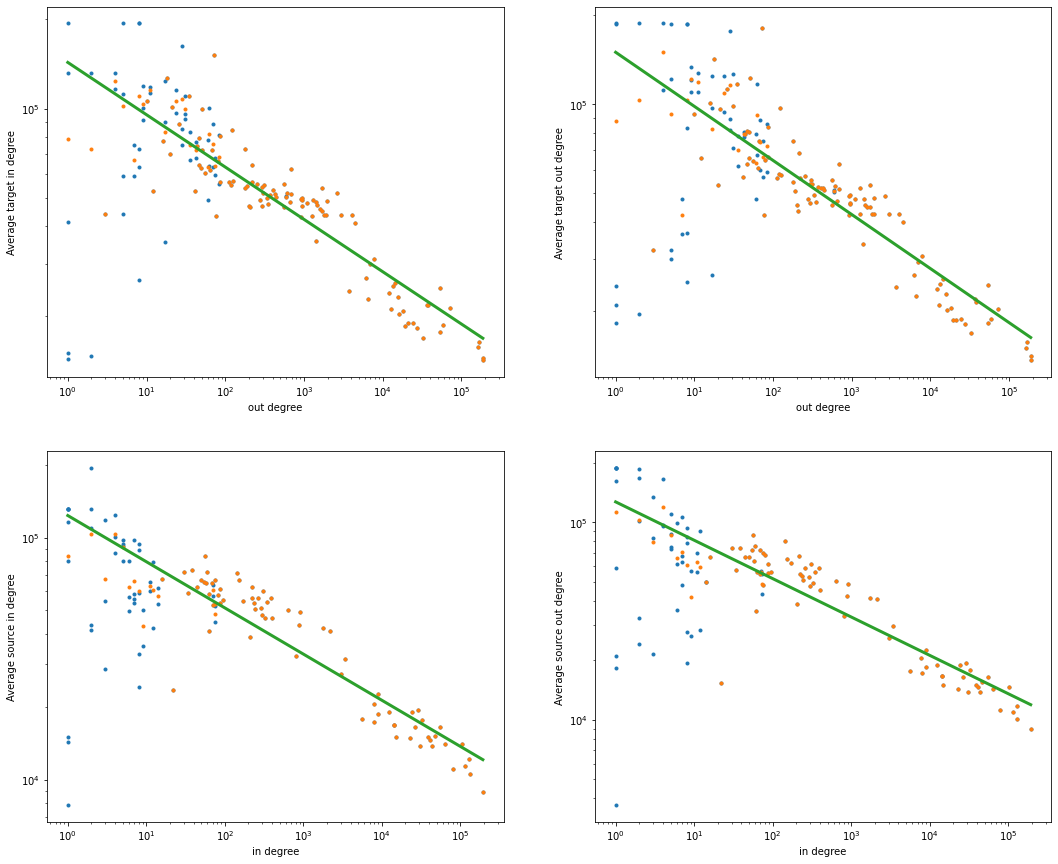

(-0.17644093588481982, -0.1826865894999842, -0.1908311792419887, -0.19417524253887586)


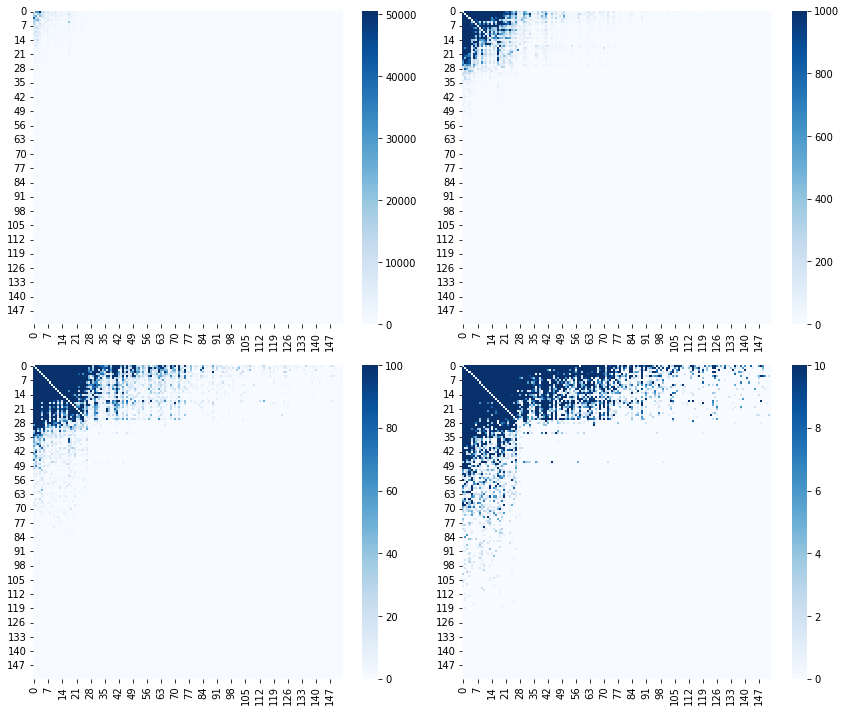

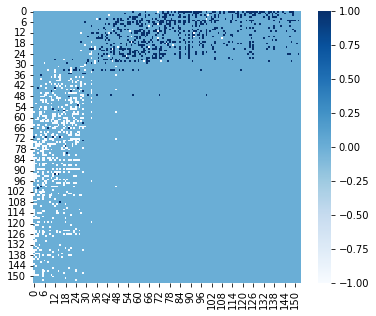

In [9]:
country_df = country19_df.append(country18_df)
country_df = country_df.append(country17_df)
country_df = country_df.append(country16_df)
country_df = country_df.append(country15_df)
country_df = country_df.append(country14_df)
analysis(country_df)

This is only a draft version of community detection

In [10]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


NameError: name 'adj_matrix_crs' is not defined

## Geographic Heat map 

In [ ]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

In [ ]:
# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank authority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)

In [ ]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# Countries ordered by PageRank hub score
display(european_df[['country', 'PageRank hub']].sort_values('PageRank hub', ascending=False))
# Countries ordered by PageRank authority score
display(european_df[['country', 'PageRank authority']].sort_values('PageRank authority', ascending=False))

country  PageRank hub
51           Spain      0.109555
88         Germany      0.108978
104          Italy      0.097891
78          France      0.089319
108         Turkey      0.043546
..             ...           ...
72         Moldova      0.002014
14         Belarus      0.001926
106     Montenegro      0.001711
48   Liechtenstein      0.001487
147    Switzerland      0.000000

[41 rows x 2 columns]

country  PageRank authority
51            Spain            0.127210
88          Germany            0.086031
78           France            0.084201
104           Italy            0.080548
64   United Kingdom            0.062429
..              ...                 ...
106      Montenegro            0.001122
75           Kosovo            0.001115
14          Belarus            0.001110
72          Moldova            0.001080
147     Switzerland            0.000000

[41 rows x 2 columns]

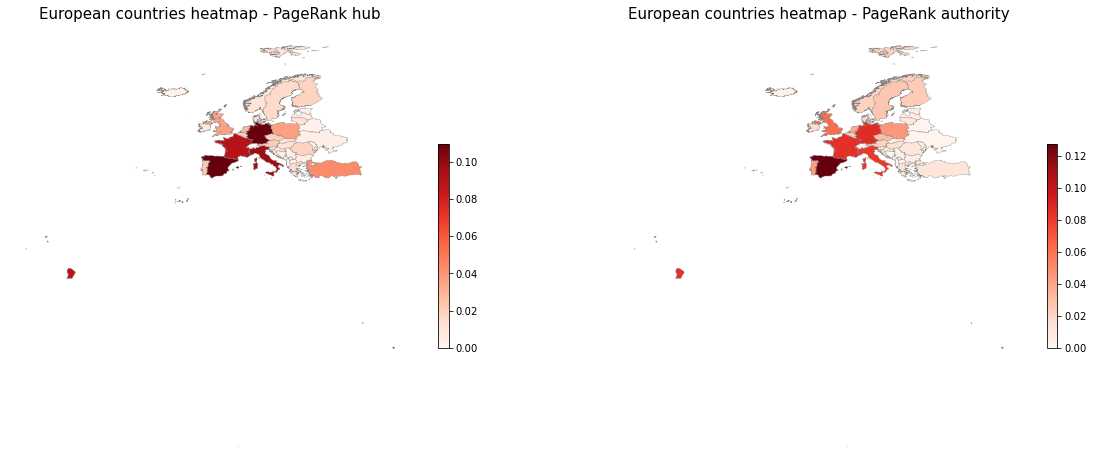

In [ ]:
# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
plt_list = ['PageRank hub', 'PageRank authority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)

# ax4 = np.reshape(ax4, (2,2))
# plt.savefig('eu_pagerank.png')

## Erasmus exchanges vs total students enrolled per country

In [ ]:
# dataset containing for each european university the students enrolled in ISCED 5-7 (tertiary education and master degree)
isced57_df = pd.read_csv("eter-export-2016_loc.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()


        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')

print('Top 10 countries for students enrollment')
display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
31          Turkey                          7107650.0
24         Germany                          2625241.0
11  United Kingdom                          2263020.0
28           Italy                          1797986.0
9            Spain                          1491419.0
26          Poland                          1418588.0
12     Netherlands                           720583.0
25          Greece                           704969.0
20          Sweden                           438578.0
4         Portugal                           323467.0

In [ ]:
european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

# threshold set because some countries had too big values wrt the average
european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)
# maybe set better this thresholds

eu_w_copy = european_df_w.copy()
eu_w_copy.dropna(inplace = True)
# Countries ordered by weighted PageRank hub score
eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_hub']])
# Countries ordered by weighted PageRank authority score
eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_aut']])


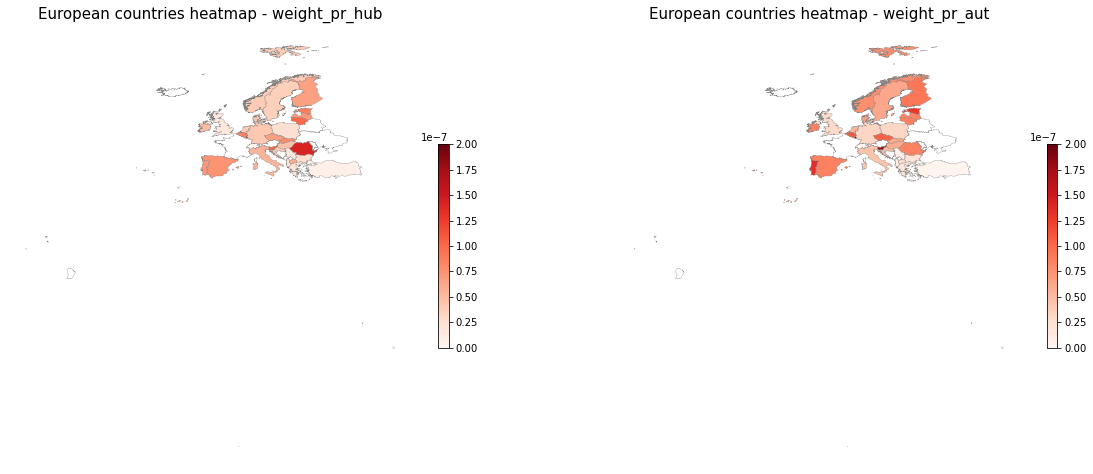

In [ ]:
fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
plt_list = ['weight_pr_hub', 'weight_pr_aut']
for i in range(len(plt_list)):
    # european_df_w.drop(european_df_w[plt_list[i]].idxmax(), inplace=True)
    european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                              vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
    ax7[i].axis('off')
    fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
    ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
# plt.savefig('eu_pagerank_weight.png')

## GeoPlot for Communities

Text(0.5, 1.0, 'European countries - Commmunity')

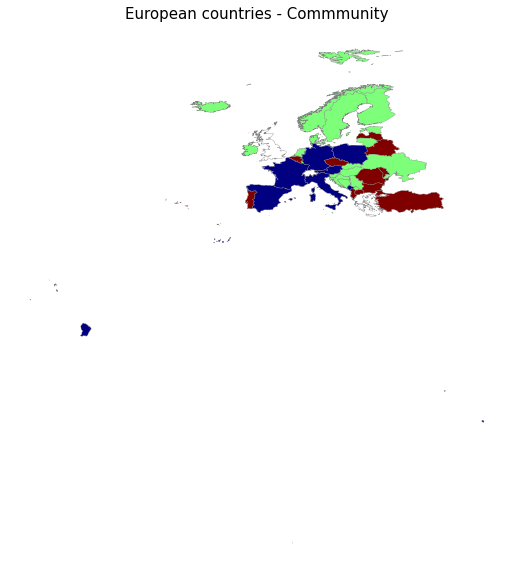

In [ ]:
node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

eu_communities = european_df.copy()
eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

fig5, ax5 = plt.subplots(figsize=(10,10))
eu_communities.plot(column='Community', ax=ax5, edgecolor='0.5', linewidth=0.3, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

# plt.savefig('eu_community.png')